# 2) <u> ML Capstone: FOREX TS Forecasting - EDA, Classical Models, FB Prophet </u>

<font color='blue'> Scripts by Kevin Jeswani
<br>
WeCloudData Bootcamp 2022 (Part-time Cohort)<br> </font>

First financial FOREX ticker and other indicator data is gathered from the EODHD API

The set of scripts in the folder 'FOREX_Forecasting_Scripts' are segmented for the purpose of clarity & convenience <br>
The following is the suggested order for running the scripts:
- '1_KJ_Forex_TS_Forecasting_DataGathering_Processing.ipynb' - Gathering data from the EODHD API, inspecting, cleaning, merging the forex data
- '2_KJ_Forex_TS_Forecasting_EDA_VARMAX_Prophet.ipynb' **This Script** - Exploratory data analysis (correlation), classical time series analysis (ACF/PACF) + VARMAX, Facebook Prophet
- '3_KJ_Forex_TS_Forecasting_SkForecast.ipynb' - Boosted tree  (XGB, LGBM, CatBoost, RandomForest ensemble) time series regression models, with backtesting/timeseries cross validation.
- '4_KJ_Forex_TS_Forecasting_LSTM.ipynb' - LSTM (RNNs) models.

Data is gathered from:
- The EOD Historical Data API: https://eodhistoricaldata.com/
- Unofficial Python SDK for EODHD: https://github.com/LautaroParada/eod-data
- OECD.Stats
<br>

## Standard Imports and General Settings

In [1]:
import timeit #To time processes
import warnings

# Data Processing
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn', override copywithsetting
import numpy as np
import csv
import time
import datetime # required for creating date-time arrays or unix time codes for EODHD intra-day
from datetime import timedelta

# Data Storage
import csv
import h5py # For writing, reading, managing results as hdf5 files
from pandas import HDFStore
import dill #Save results from ipynb session

import h5glance # For visualizing HDF5 file structures and data types
from h5glance import H5Glance
import tables #pytables

# Plotting
import matplotlib as mpl #Matplot lib
import matplotlib.pyplot as plt #pyplot
import matplotlib.dates as mdates
import mplfinance as mplf #stock-related plots
import plotly.express as px #plotly express
import plotly.io as pio
import plotly.graph_objects as go #for candlestick charts
import kaleido #sub-library required for saving plotly
import seaborn as sns #seaborn

sns.set() 

# Statistical Packages & Classical Models
import statsmodels.api as sm #general stats
from statsmodels.tsa.seasonal import seasonal_decompose #time-series decomoposition
from statsmodels.tsa.stattools import adfuller, kpss, coint #AD-Fuller and KPSS Statistic stationary tests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #ACF and PACF charts for checking TS lagged correlations

# VARMAX - StatsModels vs. AutoARIMA
from statsmodels.tsa.ar_model import AutoReg #Auto-regressive models for VARMAX
from statsmodels.tsa.statespace.varmax import VARMAX #vectorized AR with exogenous variables
from statsmodels.tsa.vector_ar.vecm import coint_johansen #cointegration testing for exgonous vars
from pmdarima import auto_arima #for auto determination of p,q,d
#from pmdarima import model_selection
from pmdarima import utils #additional utilies from autoarima

# SkLearn - ML
import sklearn
# Evaluation metrics
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE, r2_score

#Facebook Prophet - streamlined seasonal forecasting package
import prophet
from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics #evaluation

In [2]:
root = r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Capstone\Forex\Scripts'
root_raw = r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Capstone\Forex\Scripts\Scraped_Data'
root_results = r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Capstone\Forex\Scripts\Results'

In [3]:
# General pandas display otpions
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)
pd.set_option('display.min_rows', 10)

In [4]:
# Store ipynb session results 
#dill.dump_session('Forex_TimeSeries_6.db')
#dill.load_session('Forex_TimeSeries_1.db')

Generate currency lists

In [159]:
from itertools import combinations
currencies = ['EUR','USD','CAD','JPY','CHF','INR']
curr_pairs = ["".join(map(str, comb)) for comb in combinations(currencies, 2)] #Create currency pairs 
tickers = [c+'.FOREX' for c in curr_pairs]

## Load Data

Merged daily ticker data with technical indicators, sentiment, macroeconomic indicators

In [133]:
df_daily = pd.read_csv(root_raw+'\FOREX_Merged_EOD_Indicators_Sentiment_MacroEcon.csv')

In [134]:
df_daily['date'] = df_daily['date'].astype('datetime64[ns]')# Column for date only - set as datetime64
df_daily['timestamp'] = df_daily['timestamp'].astype('datetime64[ns]') #set as datetime64
df_daily.set_index('timestamp',inplace=True) #set the date-time of as the index

Intra-day ticker day sampled at 15min increments

In [9]:
# Load Intra-day Tick Data
increment = '15m' 
IDTicks = {}
for t,ticker in enumerate(tickers):
    #load from h5 for each ticker
    df_ID = pd.read_hdf(root_raw+r'\FOREX_15min.h5',mode='r+',key='/'+ticker.replace(".","_")+'_'+increment) 
    # Store to dictionary
    IDTicks[ticker] = df_ID

# Exploratory Data Analysis

 Check the technical analysis indicators, EOD closing price (adjusted for splits & dividends), and new sentiment data developed in the data gathering phase.

## Feature Correlation

From the data gathering and processing notebook, it can be seen that values for JPY-INR require further data cleaning as strange outputs of technical indicators arose. It will be ignored this currency pair whenever making an analysis of closing price and the technical indicators. Further exploration is deem out of the scope of this project at this phase.

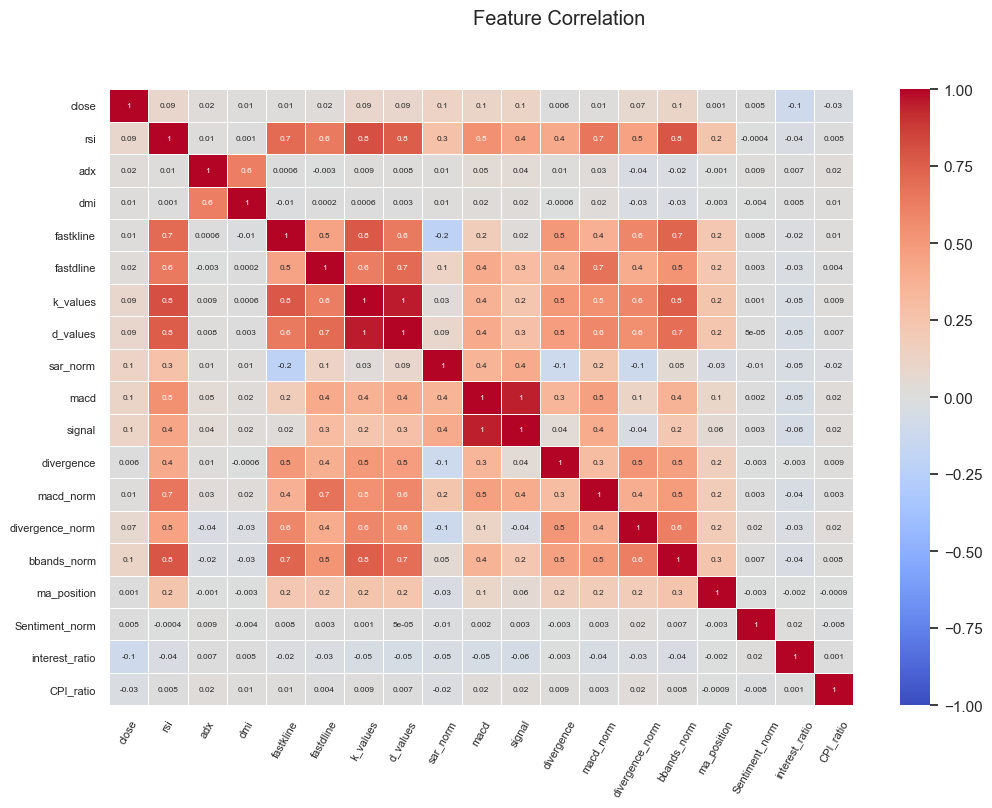

In [107]:
# Examine correlation
# reduce the features to examine to only normalized
df = df_daily[df_daily['Ticker']!='JPYINR.FOREX'] #remove ticker with strange indicator values
df = df[['close', 'rsi','adx', 'dmi', 'fastkline', 'fastdline', 'k_values', 'd_values',
          'sar_norm', 'macd', 'signal', 'divergence', 'macd_norm','divergence_norm', 'bbands_norm', 'ma_position',
               'Sentiment_norm','interest_ratio','CPI_ratio']]
fig, ax = plt.subplots(figsize = (12,8))
sns.heatmap(df.corr(), fmt='.1g', annot = True, ax=ax,linewidths=.5,annot_kws={"size":6}, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
bottom, top = ax.get_ylim()
plt.xticks(rotation=60) 
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)
fig.suptitle('Feature Correlation')
fid = r'\FeatureCorrelation_noLag.png'
plt.savefig(root_results+fid, format='png', dpi=600,bbox_inches='tight')

It can be seen that there is a weak correlation with all of the indicators and the close price. <br>
Experiment with shifting the close 7 to 21-days backward such that indicators may signal an upcoming trend.

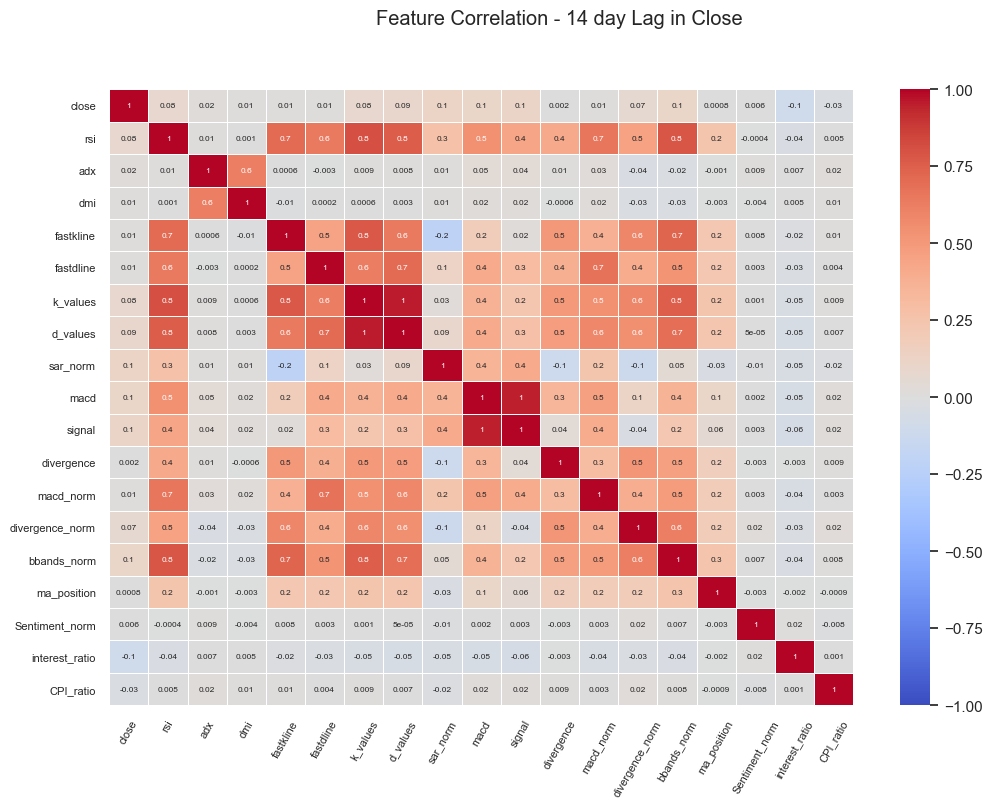

In [108]:
# Examine correlation
# reduce the features to examine to only normalized
df['close'] = df['close'].shift(-14).ffill() #14-day shift backward
fig, ax = plt.subplots(figsize = (12,8))
sns.heatmap(df.corr(), fmt='.1g', annot = True, ax=ax,linewidths=.5,annot_kws={"size":6}, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
bottom, top = ax.get_ylim()
plt.xticks(rotation=60) 
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)
fig.suptitle('Feature Correlation - 14 day Lag in Close')
fid = r'\FeatureCorrelation_14-dayLag.png'
plt.savefig(root_results+fid, format='png', dpi=600,bbox_inches='tight')

There is little improvement suggesting simple trends between the close price and other indicators cannot be found. However, there is a lot of correlation when comparing the normalized indicators.

## Currency Pair Closing Exchange Rate Correlation

In [12]:
# Create df with the fine-grained close price of all exchanges as individual series
df_close = pd.DataFrame(IDTicks[tickers[0]]['close']) #initialize df with first ticker closing values
for t,ticker in enumerate(tickers[1:]): #cycle through other tickers
    df_close = pd.concat([df_close,IDTicks[ticker]['close']],axis=1) #concatenate horizontally
df_close.columns = tickers #set the column names to the ticker tag
df_close = df_close.dropna() #drop all null rows

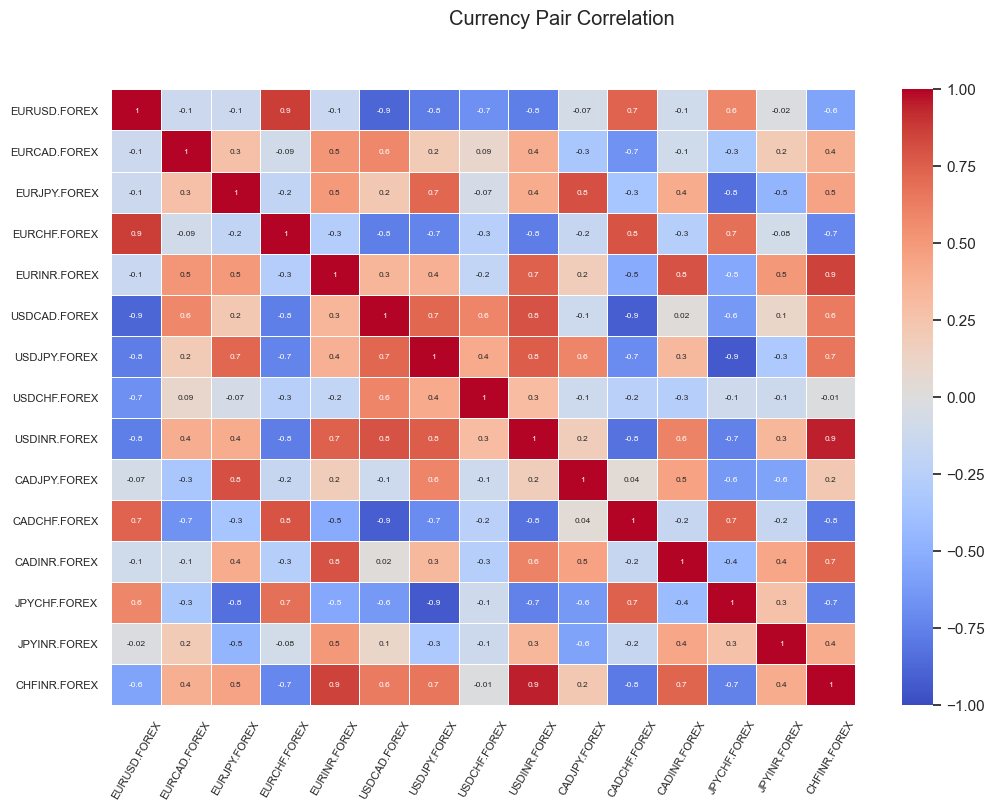

In [111]:
fig, ax = plt.subplots(figsize = (12,8))
sns.heatmap(df_close.corr(), fmt='.1g', annot = True, ax=ax,linewidths=.5,annot_kws={"size":6}, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
bottom, top = ax.get_ylim()
plt.xticks(rotation=60) 
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)
fig.suptitle('Currency Pair Correlation')
fid = r'\CurrencyPairCorrelation.png'
plt.savefig(root_results+fid, format='png', dpi=600,bbox_inches='tight')

## Check for Seasonality / Determine Stationarity

Stationary = mean and variance of the series do not vary over time; effectively seasonality is present in the time series

### Augmented Dickey-Fuller (ADFuller)

Test for Stationarity = Augmented Dickery-Fuller Test: <br>
Ho = null hypothesis = time-series is non-stationary <br>
H1 = alternative hypothesis = time-series is stationary <br>
If p-values > 0.05, fail to reject the null hypothesis = data is non-stationary<br>
If ADF statistic > critical values, fail to reject the null hypothesis = data is non-stationary <br>

IF the prices are non-stationary then it will be inappropriate to use auto-regressive moving average (ARMA)-type models

In [14]:
# Specify list of lags to try - rather than running [0:2*365] which takes a lot of unncessary processing power
lag_test = [7,14,30,60,120,180,270,365,int(1.25*365),int(1.75*365),int(2*365)]
ADFstats = ['ADF','p-val','>critvals?']
ADF_labels = [s+'_'+str(l) for l in lag_test for s in ADFstats]

In [16]:
# initialize empty df
start_date = datetime.datetime.strptime('2010-01-01',"%Y-%m-%d")
ADFullers = pd.DataFrame(data=np.empty(shape=(len(tickers), len(ADF_labels)), dtype='float64'),columns=ADF_labels,index=tickers)
for t,ticker in enumerate(tickers):
    # Extract price series, filter for ticker, and last 5 years
    price = df_daily[(df_daily['Ticker']==ticker) &(df_daily['date'] > start_date)]['close']    
    count = 0 #initialize counter
    for l,lag in enumerate(lag_test):
        # Store ADF test result for the given lag
        ADfuller = adfuller(price,maxlag=lag,autolag=None,regression='ct')
        ADFullers.loc[ticker,ADF_labels[count]] = round(ADfuller[0],4) #KPSS Statistic
        ADFullers.loc[ticker,ADF_labels[count+1]] = ADfuller[1] #p-value
        # Create a list of booleans for the 1,5, and 10% critical values compared to KPSS stat
        if  (ADfuller[4]['10%'] <= ADfuller[0]):
            crit_bool = '>10%'
        elif (ADfuller[4]['5%'] <= ADfuller[0]):
            crit_bool = '>5%'
        elif (ADfuller[4]['1%'] <= ADfuller[0]):
            crit_bool ='>1%'
        else:
            crit_bool ='<all'   
        ADFullers.loc[ticker,ADF_labels[count+2]] = crit_bool
        count+=len(ADFstats) #use counter to moderate column

In [17]:
pd.options.display.float_format = '{:.3f}'.format
ADFullers

ADF_7  p-val_7 >critvals?_7  ADF_14  p-val_14 >critvals?_14  \
EURUSD.FOREX -2.152    0.517         >10%  -2.005     0.599          >10%   
EURCAD.FOREX -2.355    0.404         >10%  -2.140     0.524          >10%   
EURJPY.FOREX -1.970    0.618         >10%  -1.849     0.681          >10%   
EURCHF.FOREX -4.243    0.004         <all  -4.258     0.004          <all   
EURINR.FOREX -2.564    0.297         >10%  -2.404     0.378          >10%   
USDCAD.FOREX -1.905    0.652         >10%  -1.856     0.677          >10%   
USDJPY.FOREX -0.712    0.972         >10%  -0.657     0.976          >10%   
USDCHF.FOREX -3.858    0.014          >1%  -3.447     0.045           >1%   
USDINR.FOREX -2.783    0.203         >10%  -3.010     0.129          >10%   
CADJPY.FOREX -1.555    0.809         >10%  -1.347     0.876          >10%   
CADCHF.FOREX -3.146    0.096          >5%  -2.654     0.256          >10%   
CADINR.FOREX -2.534    0.311         >10%  -2.535     0.311          >10%   
JPYCHF.FOREX -2.055    0.571         >10%  -2.015     0.593          >10%   
JPYINR.FOREX -3.339    0.060          >5%  -3.244     0.076           >5%   
CHFINR.FOREX -3.689    0.023          >1%  -3.309     0.065           >5%   

              ADF_30  p-val_30 >critvals?_30  ADF_60  p-val_60 >critvals?_60  \
EURUSD.FOREX  -2.014     0.594          >10%  -2.354     0.404          >10%   
EURCAD.FOREX  -1.849     0.681          >10%  -1.665     0.766          >10%   
EURJPY.FOREX  -1.880     0.665          >10%  -2.084     0.555          >10%   
EURCHF.FOREX  -3.735     0.020           >1%  -3.039     0.122          >10%   
EURINR.FOREX  -2.255     0.459          >10%  -2.758     0.213          >10%   
USDCAD.FOREX  -1.871     0.670          >10%  -1.666     0.766          >10%   
USDJPY.FOREX  -0.741     0.970          >10%  -1.312     0.885          >10%   
USDCHF.FOREX  -3.247     0.076           >5%  -3.096     0.107          >10%   
USDINR.FOREX  -2.856     0.177          >10%  -2.903     0.161          >10%   
CADJPY.FOREX  -1.279     0.893          >10%  -1.135     0.923          >10%   
CADCHF.FOREX  -2.543     0.307          >10%  -2.491     0.333          >10%   
CADINR.FOREX  -2.405     0.377          >10%  -2.425     0.366          >10%   
JPYCHF.FOREX  -2.150     0.518          >10%  -2.200     0.490          >10%   
JPYINR.FOREX  -2.541     0.308          >10%  -2.467     0.344          >10%   
CHFINR.FOREX  -3.224     0.080           >5%  -3.060     0.116          >10%   

              ADF_120  p-val_120 >critvals?_120  ADF_180  p-val_180  \
EURUSD.FOREX   -2.592      0.284           >10%   -3.122      0.101   
EURCAD.FOREX   -1.833      0.689           >10%   -2.432      0.363   
EURJPY.FOREX   -1.943      0.632           >10%   -2.358      0.402   
EURCHF.FOREX   -2.554      0.302           >10%   -2.937      0.151   
EURINR.FOREX   -2.529      0.314           >10%   -3.248      0.075   
USDCAD.FOREX   -1.495      0.831           >10%   -1.548      0.812   
USDJPY.FOREX   -1.298      0.888           >10%   -1.618      0.785   
USDCHF.FOREX   -2.532      0.312           >10%   -2.611      0.275   
USDINR.FOREX   -2.793      0.200           >10%   -3.563      0.033   
CADJPY.FOREX   -0.936      0.952           >10%   -1.229      0.904   
CADCHF.FOREX   -2.096      0.548           >10%   -1.981      0.612   
CADINR.FOREX   -2.105      0.543           >10%   -1.824      0.693   
JPYCHF.FOREX   -1.839      0.686           >10%   -1.891      0.659   
JPYINR.FOREX   -2.510      0.323           >10%   -2.338      0.413   
CHFINR.FOREX   -2.904      0.161           >10%   -2.729      0.224   

             >critvals?_180  ADF_270  p-val_270 >critvals?_270  ADF_365  \
EURUSD.FOREX           >10%   -2.700      0.236           >10%   -2.006   
EURCAD.FOREX           >10%   -1.825      0.693           >10%   -1.183   
EURJPY.FOREX           >10%   -3.196      0.085            >5%   -2.456   
EURCHF.FOREX           >10%   -2.531      0.313           >10% 

In [18]:
# Filter for where the lags where p-values <0.05 (& close to it, say 0.08)
filter_ADF = ADFullers.filter(like='p-val',axis=1)<0.08
filter_ADF.loc[:,filter_ADF.any(axis=0)]

p-val_7  p-val_14  p-val_30  p-val_180  p-val_365  p-val_638
EURUSD.FOREX    False     False     False      False      False      False
EURCAD.FOREX    False     False     False      False      False      False
EURJPY.FOREX    False     False     False      False      False      False
EURCHF.FOREX     True      True      True      False      False      False
EURINR.FOREX    False     False     False       True      False       True
USDCAD.FOREX    False     False     False      False      False      False
USDJPY.FOREX    False     False     False      False      False      False
USDCHF.FOREX     True      True      True      False      False      False
USDINR.FOREX    False     False     False       True       True      False
CADJPY.FOREX    False     False     False      False      False      False
CADCHF.FOREX    False     False     False      False      False      False
CADINR.FOREX    False     False     False      False      False      False
JPYCHF.FOREX    False     False     False      False      False      False
JPYINR.FOREX     True      True     False      False      False      False
CHFINR.FOREX     True      True      True      False      False      False

In [64]:
# Determine which lag produces the max p-value, to be used as a period for decomposition:
min_p_adf = ADFullers.filter(like='p-val',axis=1).min(axis=1) #filter for p-val columns, get the max value = most stationary
lag_adf = ADFullers.filter(like='p-val',axis=1).idxmin(axis = 1).map(lambda x: x.lstrip('p-val_')) #get the corresponding column, strip the prefix string

In [65]:
ADFullers_bestlag = pd.DataFrame(zip(max_p_adf,lag_adf),index=tickers,columns=['min p-val ADF','lag ADF']) #pass zip of two lists to df

Where the ADFuller statistic is less than 1%,5%,& 10% critical values & p-value >0.05 = Fail to reject Ho for most currency pairs, i.e. non-stationary exchange rates. <br>
Exceptions include: <br>
- ADF stat > critical values & p-value <0.05 for USD-CHF & EUR-CHF, i.e., data is stationary for at least one lag period
- JPY-INR, CHF-INF, USD-INR, and EUR-INR have p-values of 0.06-0.09 (close to 0.05) and ADF stat greater than at least 2 critical values for some lag periods. Data is moderately non-stationary.

Sources: https://machinelearningmastery.com/time-series-data-stationary-python/#:~:text=The%20Augmented%20Dickey%2DFuller%20test,of%20the%20more%20widely%20used. <br>

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

IF the prices are non-stationary then it will be inappropriate to use auto-regressive moving average (ARMA)-type models

Ho = null hypothesis = time-series is stationary <br>
H1 = alternative hypothesis = time-series is non-stationary <br>
If p-values > 0.05, fail to reject the null hypothesis = data is stationary<br> 
https://www.statology.org/kpss-test-in-python/

In [21]:
# Specify list of lags to try
lag_test = [7,14,30,60,120,180,270,365,int(1.25*365),int(1.75*365),int(2*365)]

In [23]:
# initialize empty df
KPSSstats = ['KPSS','p-val','>critvals?']
kpss_labels = [s+'_'+str(l) for l in lag_test for s in KPSSstats]
KPSSs = pd.DataFrame(data=np.empty(shape=(len(tickers), len(kpss_labels)), dtype='float64'),columns=kpss_labels,index=tickers)
for t,ticker in enumerate(tickers):
    # Extract price series, filter for ticker, and last 5 years
    price = df_daily[(df_daily['Ticker']==ticker) &(df_daily['date'] > start_date)]['close']    
    warnings.simplefilter(action='ignore') #mute warnings
    count = 0 #initialize counter
    for l,lag in enumerate(lag_test):
        # Store KPSS test result for the given lag
        kpss_test = kpss(price, regression='ct',nlags=lag) #'ct' for testing null hypothesis of stationarity around a trend
        KPSSs.loc[ticker,kpss_labels[count]] = round(kpss_test[0],4) #KPSS Statistic
        KPSSs.loc[ticker,kpss_labels[count+1]] = kpss_test[1] #p-value
        # Create a list of booleans for the 1,5, and 10% critical values compared to KPSS stat
        if  (kpss_test[3]['1%'] <= kpss_test[0]):
            crit_bool = '>1%'
        elif (kpss_test[3]['5%'] <= kpss_test[0]):
            crit_bool = '>5%'
        elif (kpss_test[3]['10%'] <= kpss_test[0]):
            crit_bool ='>10%'
        else:
            crit_bool ='<all'   
        KPSSs.loc[ticker,kpss_labels[count+2]] = crit_bool
        count+=len(KPSSstats) #use counter to moderate column

In [24]:
KPSSs

KPSS_7  p-val_7 >critvals?_7  KPSS_14  p-val_14 >critvals?_14  \
EURUSD.FOREX   3.613    0.010          >1%    1.942     0.010           >1%   
EURCAD.FOREX   3.688    0.010          >1%    1.994     0.010           >1%   
EURJPY.FOREX   3.038    0.010          >1%    1.632     0.010           >1%   
EURCHF.FOREX   1.669    0.010          >1%    0.915     0.010           >1%   
EURINR.FOREX   1.752    0.010          >1%    0.944     0.010           >1%   
USDCAD.FOREX   6.952    0.010          >1%    3.729     0.010           >1%   
USDJPY.FOREX   4.728    0.010          >1%    2.537     0.010           >1%   
USDCHF.FOREX   3.559    0.010          >1%    1.943     0.010           >1%   
USDINR.FOREX   4.217    0.010          >1%    2.275     0.010           >1%   
CADJPY.FOREX   3.070    0.010          >1%    1.653     0.010           >1%   
CADCHF.FOREX   4.539    0.010          >1%    2.464     0.010           >1%   
CADINR.FOREX   3.918    0.010          >1%    2.108     0.010           >1%   
JPYCHF.FOREX   4.479    0.010          >1%    2.405     0.010           >1%   
JPYINR.FOREX   2.134    0.010          >1%    1.161     0.010           >1%   
CHFINR.FOREX   2.651    0.010          >1%    1.442     0.010           >1%   

              KPSS_30  p-val_30 >critvals?_30  KPSS_60  p-val_60  \
EURUSD.FOREX    0.956     0.010           >1%    0.501     0.010   
EURCAD.FOREX    0.993     0.010           >1%    0.532     0.010   
EURJPY.FOREX    0.802     0.010           >1%    0.419     0.010   
EURCHF.FOREX    0.470     0.010           >1%    0.264     0.010   
EURINR.FOREX    0.467     0.010           >1%    0.247     0.010   
USDCAD.FOREX    1.827     0.010           >1%    0.951     0.010   
USDJPY.FOREX    1.245     0.010           >1%    0.649     0.010   
USDCHF.FOREX    0.984     0.010           >1%    0.537     0.010   
USDINR.FOREX    1.132     0.010           >1%    0.605     0.010   
CADJPY.FOREX    0.818     0.010           >1%    0.432     0.010   
CADCHF.FOREX    1.233     0.010           >1%    0.660     0.010   
CADINR.FOREX    1.041     0.010           >1%    0.550     0.010   
JPYCHF.FOREX    1.182     0.010           >1%    0.619     0.010   
JPYINR.FOREX    0.587     0.010           >1%    0.320     0.010   
CHFINR.FOREX    0.724     0.010           >1%    0.390     0.010   

             >critvals?_60  KPSS_120  p-val_120 >critvals?_120  KPSS_180  \
EURUSD.FOREX           >1%     0.270      0.010            >1%     0.196   
EURCAD.FOREX           >1%     0.298      0.010            >1%     0.222   
EURJPY.FOREX           >1%     0.224      0.010            >1%     0.160   
EURCHF.FOREX           >1%     0.153      0.044            >5%     0.114   
EURINR.FOREX           >1%     0.135      0.070           >10%     0.099   
USDCAD.FOREX           >1%     0.501      0.010            >1%     0.349   
USDJPY.FOREX           >1%     0.346      0.010            >1%     0.245   
USDCHF.FOREX           >1%     0.308      0.010            >1%     0.233   
USDINR.FOREX           >1%     0.336      0.010            >1%     0.248   
CADJPY.FOREX           >1%     0.236      0.010            >1%     0.170   
CADCHF.FOREX           >1%     0.369      0.010            >1%     0.273   
CADINR.FOREX           >1%     0.298      0.010            >1%     0.212   
JPYCHF.FOREX           >1%     0.332      0.010            >1%     0.237   
JPYINR.FOREX           >1%     0.181      0.023            >5%     0.136   
CHFINR.FOREX           >1%     0.217      0.010            >1%     0.161   

              p-val_180 >critvals?_180  KPSS_270  p-val_270 >critvals?_270  \
EURUSD.FOREX      0.018            >5%     0.150      0.047            >5%   
EURCAD.FOREX      0.010            >1%     0.177      0.025            >5%   
EURJPY.FOREX      0.039            >5%     0.118      0.100           <all   
EURCHF.FOREX      0.100           <all     0.090      0.100           <all   
EURINR.FOREX      0.100           <all     0.078     

In [25]:
# Filter for where the lags where p-values >0.05
filter_kpss = KPSSs.filter(like='p-val',axis=1)>0.05
filter_kpss.loc[:,filter_kpss.any(axis=0)]

p-val_120  p-val_180  p-val_270  p-val_365  p-val_456  \
EURUSD.FOREX      False      False      False       True       True   
EURCAD.FOREX      False      False      False      False      False   
EURJPY.FOREX      False      False       True       True       True   
EURCHF.FOREX      False       True       True       True       True   
EURINR.FOREX       True       True       True       True       True   
USDCAD.FOREX      False      False      False      False      False   
USDJPY.FOREX      False      False      False      False       True   
USDCHF.FOREX      False      False      False      False       True   
USDINR.FOREX      False      False      False      False      False   
CADJPY.FOREX      False      False       True       True       True   
CADCHF.FOREX      False      False      False      False      False   
CADINR.FOREX      False      False      False       True       True   
JPYCHF.FOREX      False      False      False       True       True   
JPYINR.FOREX      False       True       True       True       True   
CHFINR.FOREX      False      False       True       True       True   

              p-val_638  p-val_730  
EURUSD.FOREX       True       True  
EURCAD.FOREX      False      False  
EURJPY.FOREX       True       True  
EURCHF.FOREX       True       True  
EURINR.FOREX       True       True  
USDCAD.FOREX       True       True  
USDJPY.FOREX       True       True  
USDCHF.FOREX       True       True  
USDINR.FOREX       True       True  
CADJPY.FOREX       True       True  
CADCHF.FOREX       True       True  
CADINR.FOREX       True       True  
JPYCHF.FOREX       True       True  
JPYINR.FOREX       True       True  
CHFINR.FOREX       True       True

In [26]:
# Determine which lag produces the max p-value, to be used as a period for decomposition:
max_p_kpss = KPSSs.filter(like='p-val',axis=1).max(axis=1) #filter for p-val columns, get the max value = most stationary
lag_kpss = KPSSs.filter(like='p-val',axis=1).idxmax(axis = 1).map(lambda x: x.lstrip('p-val_')) #get the corresponding column, strip the prefix string

In [66]:
kpss_bestlag = pd.DataFrame(zip(max_p_kpss,lag_kpss),index=tickers,columns=['max p-val KPSS','lag KPSS']) #pass zip of two lists to df

Depending on the lag used, some degree of stationarity tests can be detected in most of the currency pairs (all except EURCAD) examined. When 1-2-year lag periods are used most (all except EURCAD) exhibit stationary behaviour.

When the curency pair is non-stationary by both tests, they have both deterministic and stochastic trends.  <br>
If both test result in stationary behaviour, then the series is stationary. <br>
When KPSS results in non-stationary while ADFuller results in stationary: there is a stochastic trend only = the series is difference-stationary. Differencing can be used to make series stationary. The differenced series can then be checked for stationarity. <br>
When KPSS results in stationary, while ADFUller results in non-stationary: the series is trend stationary. The trend can be removed and the series can be made stationary.

Source: https://towardsdatascience.com/when-a-time-series-only-quacks-like-a-duck-10de9e165e; https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#:~:text=A%20key%20difference%20from%20ADF,the%20series%20is%20non%2Dstationary.

### Seasonal Decomposition

Based on the AD-Fuller and KPSS tests, try and plot the lag period for each currency pair that results in stationary series.

Check whether seasonality has an additive or multiplicative efect on the stock price by decomposing it into the trend + seasonal signal + noise (residual). Decomposition implements moving averages.

In [67]:
#Merge the two dfs containing ideal lags for the two statistical tests
bestlags = pd.merge(left=ADFullers_bestlag,right=kpss_bestlag,how='left',left_index=True,right_index=True)
bestlags = bestlags.astype({"lag ADF":"int64","lag KPSS":"int64"}) #cast lags as int64
bestlags

min p-val ADF  lag ADF  max p-val KPSS  lag KPSS
EURUSD.FOREX          0.101      180           0.095       638
EURCAD.FOREX          0.363      180           0.049       730
EURJPY.FOREX          0.085      270           0.100       270
EURCHF.FOREX          0.004       14           0.100       180
EURINR.FOREX          0.052      638           0.100       180
USDCAD.FOREX          0.637      456           0.066       730
USDJPY.FOREX          0.581      270           0.100       638
USDCHF.FOREX          0.014        7           0.089       730
USDINR.FOREX          0.033      180           0.077       730
CADJPY.FOREX          0.698      270           0.100       365
CADCHF.FOREX          0.096        7           0.075       730
CADINR.FOREX          0.301      365           0.100       456
JPYCHF.FOREX          0.123      456           0.100       638
JPYINR.FOREX          0.060        7           0.100       270
CHFINR.FOREX          0.023        7           0.100       365

In [29]:
# We can set the periods to the best lags found from the KPSS (or ADF) test 
# ...However, we can note that the seasonal decomposition works well when using 2-year periods for most currency pairs, 
# ...and 3-year period for at least one
#periods_OR = bestlags['lag KPSS']

In [30]:
decomps = {} #initialize empty dict to store decompositions
df_decomps ={} #initialize empty dict to store the decomposed series
period_def = int(2*365) #default period
periods_OR = {'USDCHF.FOREX':int(3*365)}
start_date = datetime.datetime.strptime('2010-01-01',"%Y-%m-%d")
labels = ['Original','Trend','Seasonality','Residuals']
for t,ticker in enumerate(tickers):
    # Extract price series, filter for ticker, and last 5 years
    price = df_daily[(df_daily['Ticker']==ticker) &(df_daily['date'] > start_date)]['close']
    # Perform a seasonal decomposition
    if ticker in periods_OR.keys(): #if period override present use that period, else use default
        decomps[ticker] = seasonal_decompose(price.values, model='multiplicative', period=periods_OR[ticker]) #'multiplicative'
    else:
        decomps[ticker] = seasonal_decompose(price.values, model='multiplicative', period=period_def) #'multiplicative'
    #decomps[ticker].plot()
    # Save the results in different series
    df_decomp = pd.DataFrame(data=np.column_stack([price,decomps[ticker].trend,decomps[ticker].seasonal,decomps[ticker].resid])
                             ,columns=labels)
    # Store decompositions in global df
    df_decomps[ticker] = df_decomp

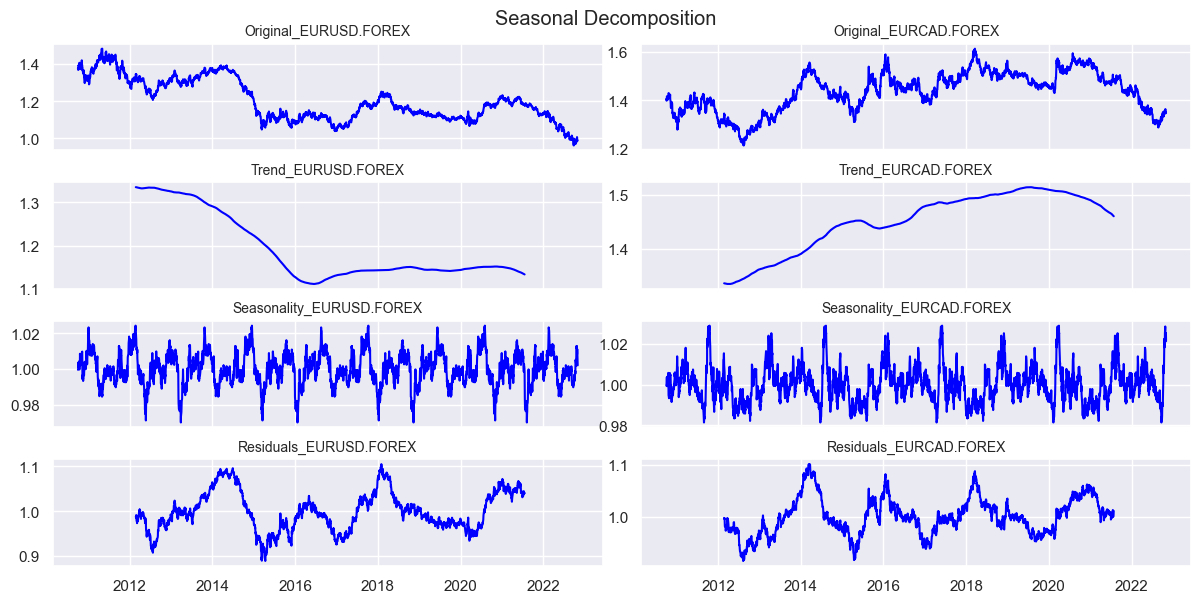

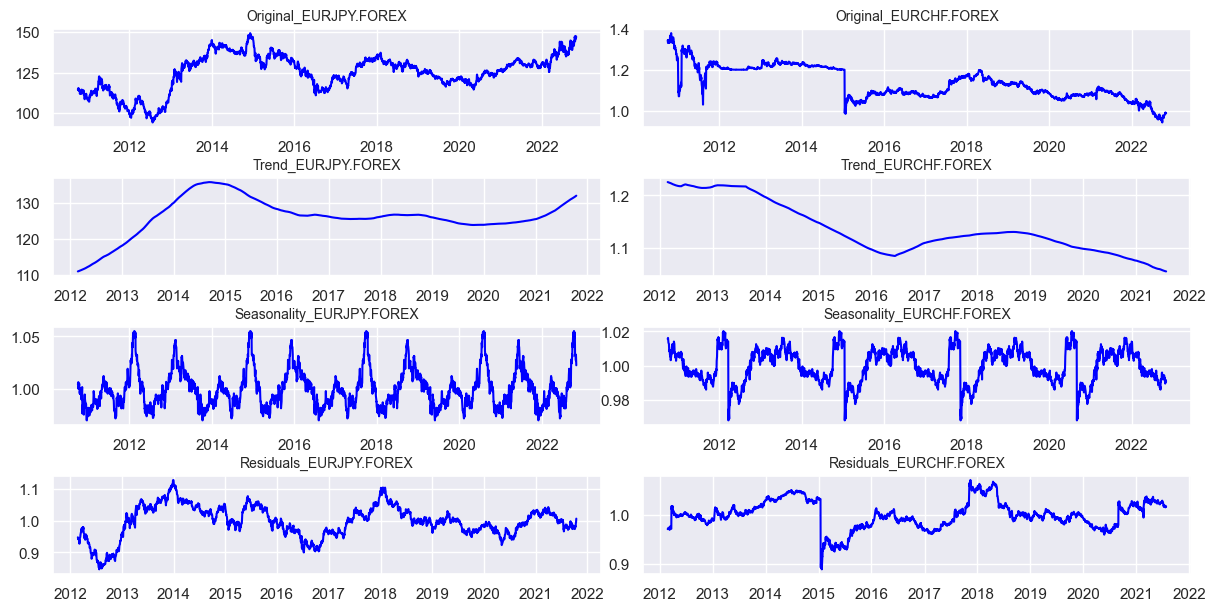

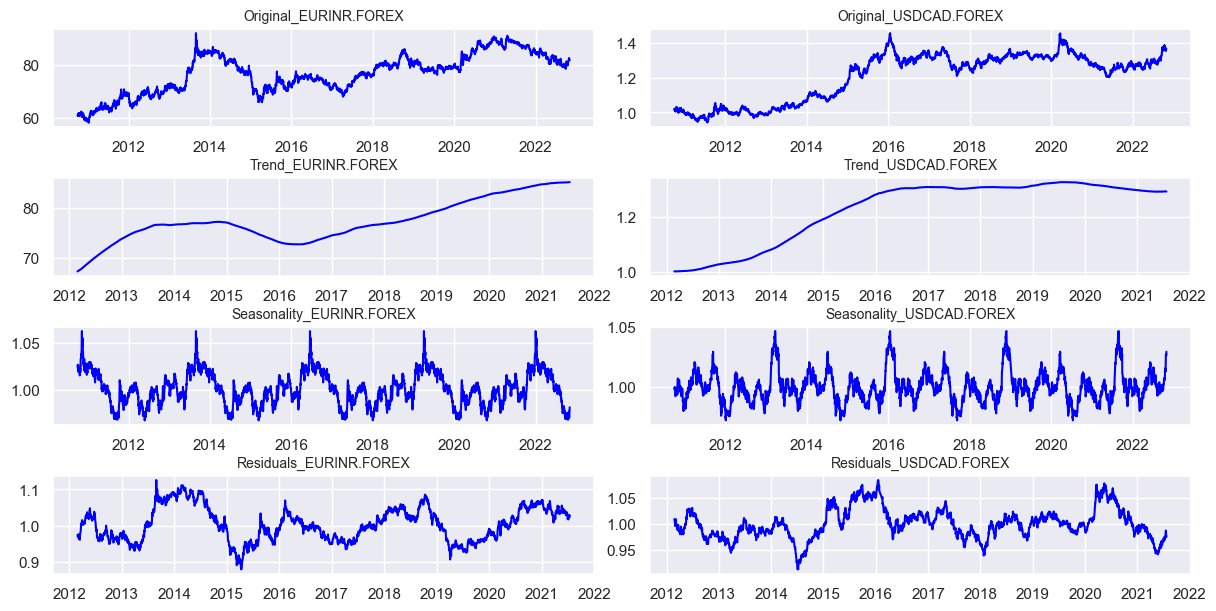

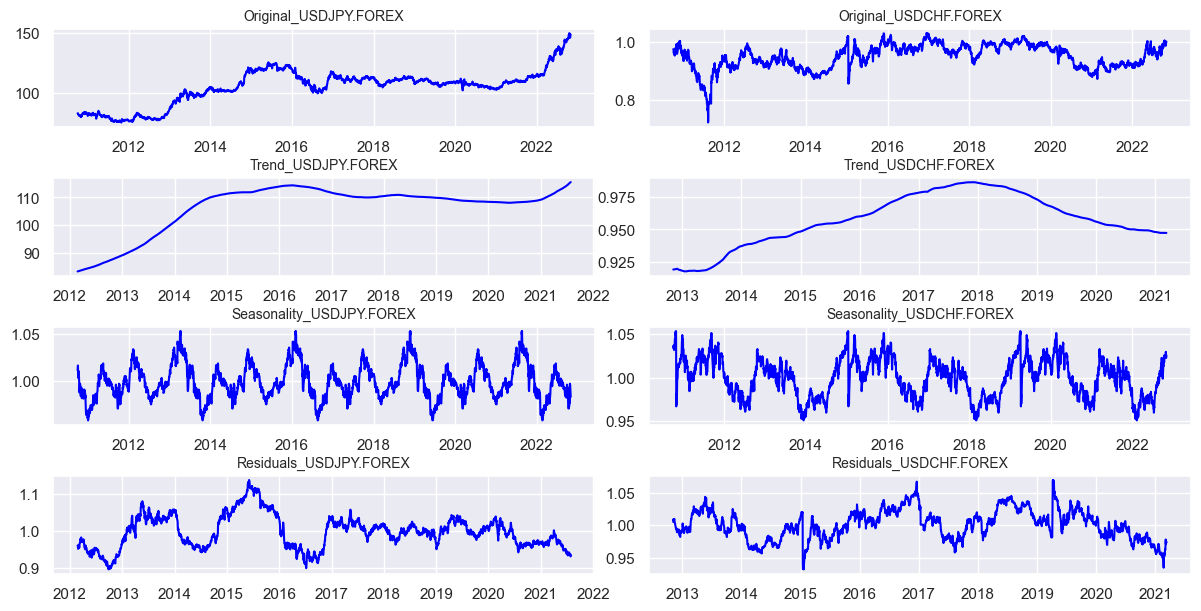

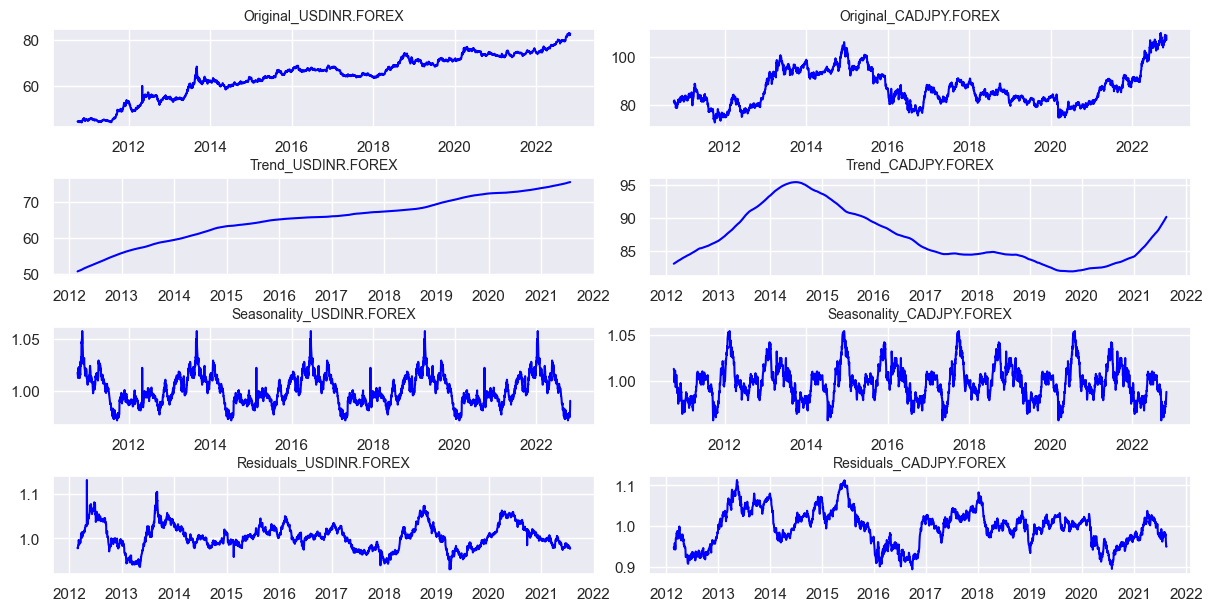

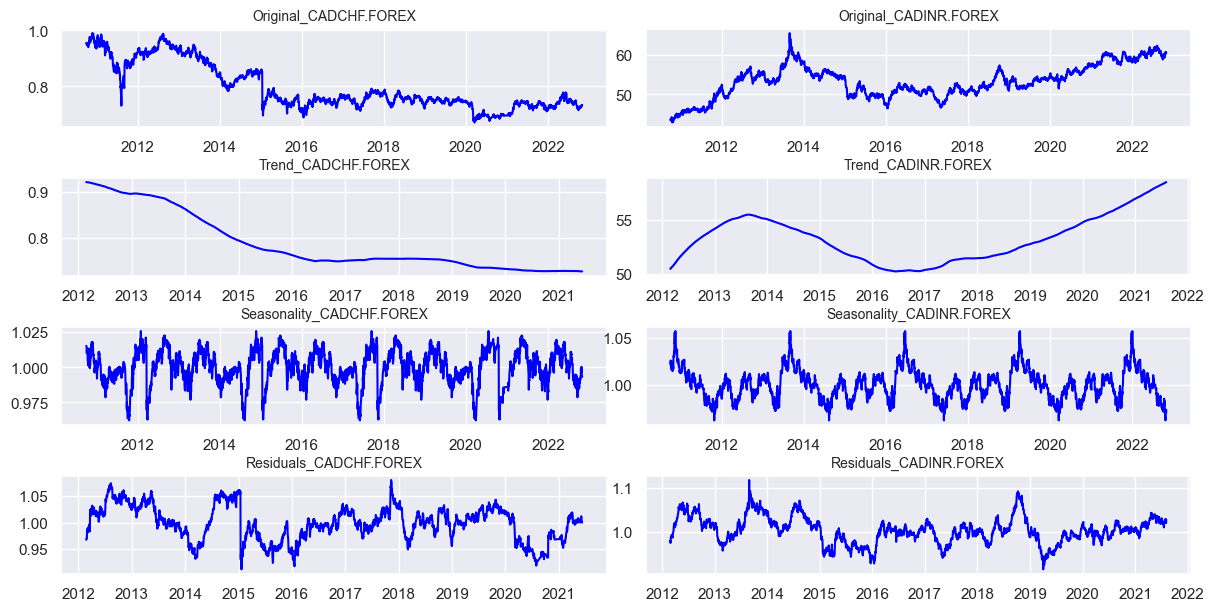

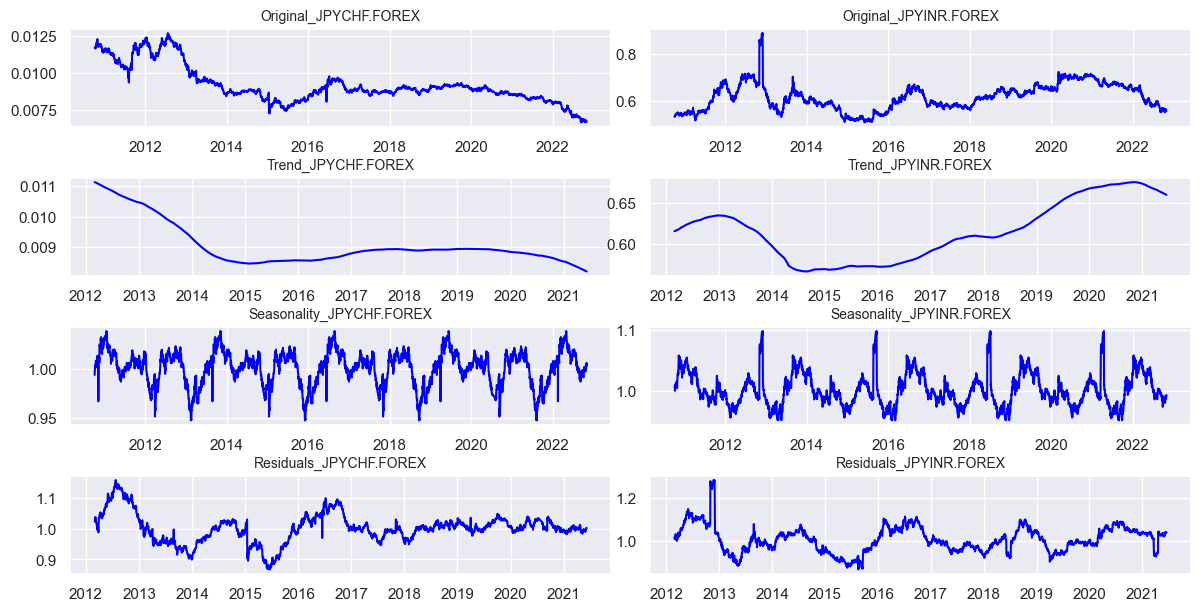

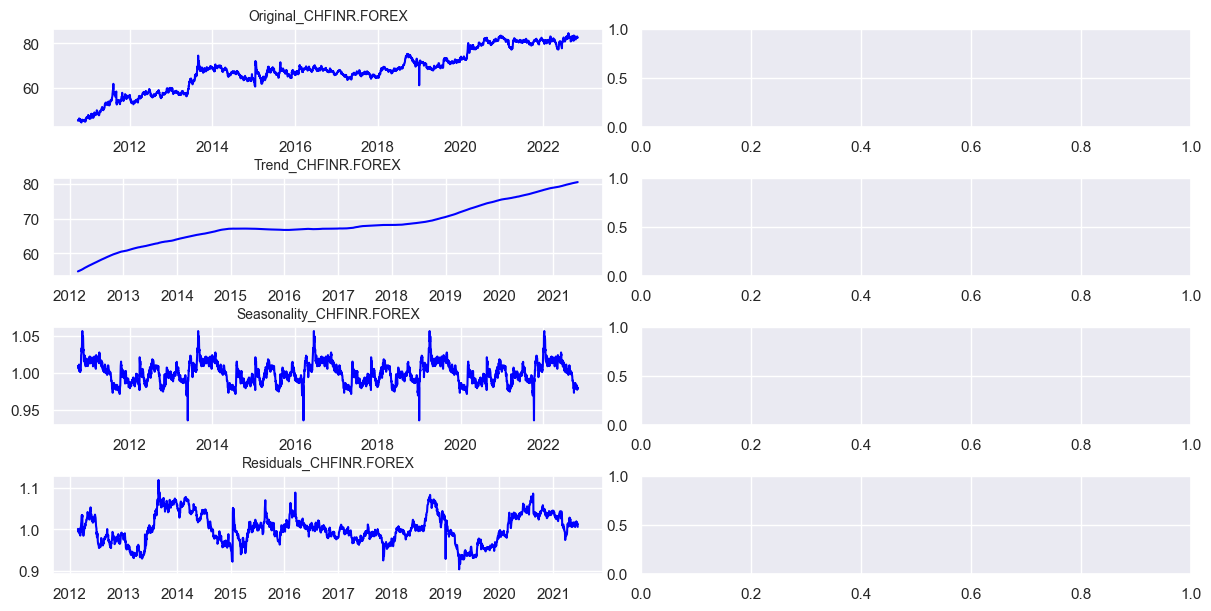

In [31]:
# Develop a more refined plot than the default ones in seasonal_decompose
# Examine 2
fig, axs = plt.subplots(4,2,figsize=(12,6),sharex='col') #initialize & store handles
#currs = ['USDCHF.FOREX','JPYINR.FOREX']
currs = tickers
c = 0 #col counter
plt.suptitle('Seasonal Decomposition')
for t, ticker in enumerate(currs): #plots for just 2 tickers
    if (t%2 == 0)&(t>0):
        fig, axs = plt.subplots(4,2,figsize=(12,6)) #initialize & store handles every 2 curr pairs
        c = 0 #col counter resets
    plt.tight_layout(pad=0.25)
    # Date array for the plot
    date = df_daily[(df_daily['Ticker']==ticker) &(df_daily['date'] > start_date)]['date']
    # Plot gathered statistics
    for a,ax in enumerate(axs):
        df = df_decomps[ticker]
        ax[c].plot(date,df[labels[a]], color="blue") #plot with the series label
        ax[c].xaxis.set_major_formatter(mdates.DateFormatter('%Y')) #manual override for datetime xticks - show only year
        ax[c].set_title(labels[a]+'_'+ticker,fontsize='small')
    c += 1 #next column for every 2nd ticker
    plt.tight_layout(pad=0.25)
    if c==1: #save the for every two pairs
        plt.savefig(root_results+'\Seasonal Decomposition '+currs[t]+'&'+currs[t-1]+'.png',
                    format='png', dpi=600,bbox_inches='tight')


One can experimenting with both additive and multiplicative seasonlity effects. With the these particular securities, either of the two seem to be reasonable based on a literature review. When experimenting with the period, 1-year to 3-year periods give higher multiplicative seasonal values. The seasonality effects affects appear to make the most sense as typically markets may run on these cycles. 

Note that the amplitudes of the multiplicative seasonality components are typically on the order of 1.05 to 1.10, with some being 0 (potentially because of the selected lag).

### ACF and PACF

Check whether patterns can be detected and for randomness. These are important for ARMA (and  AR, MA, ARIMA) models. <br>

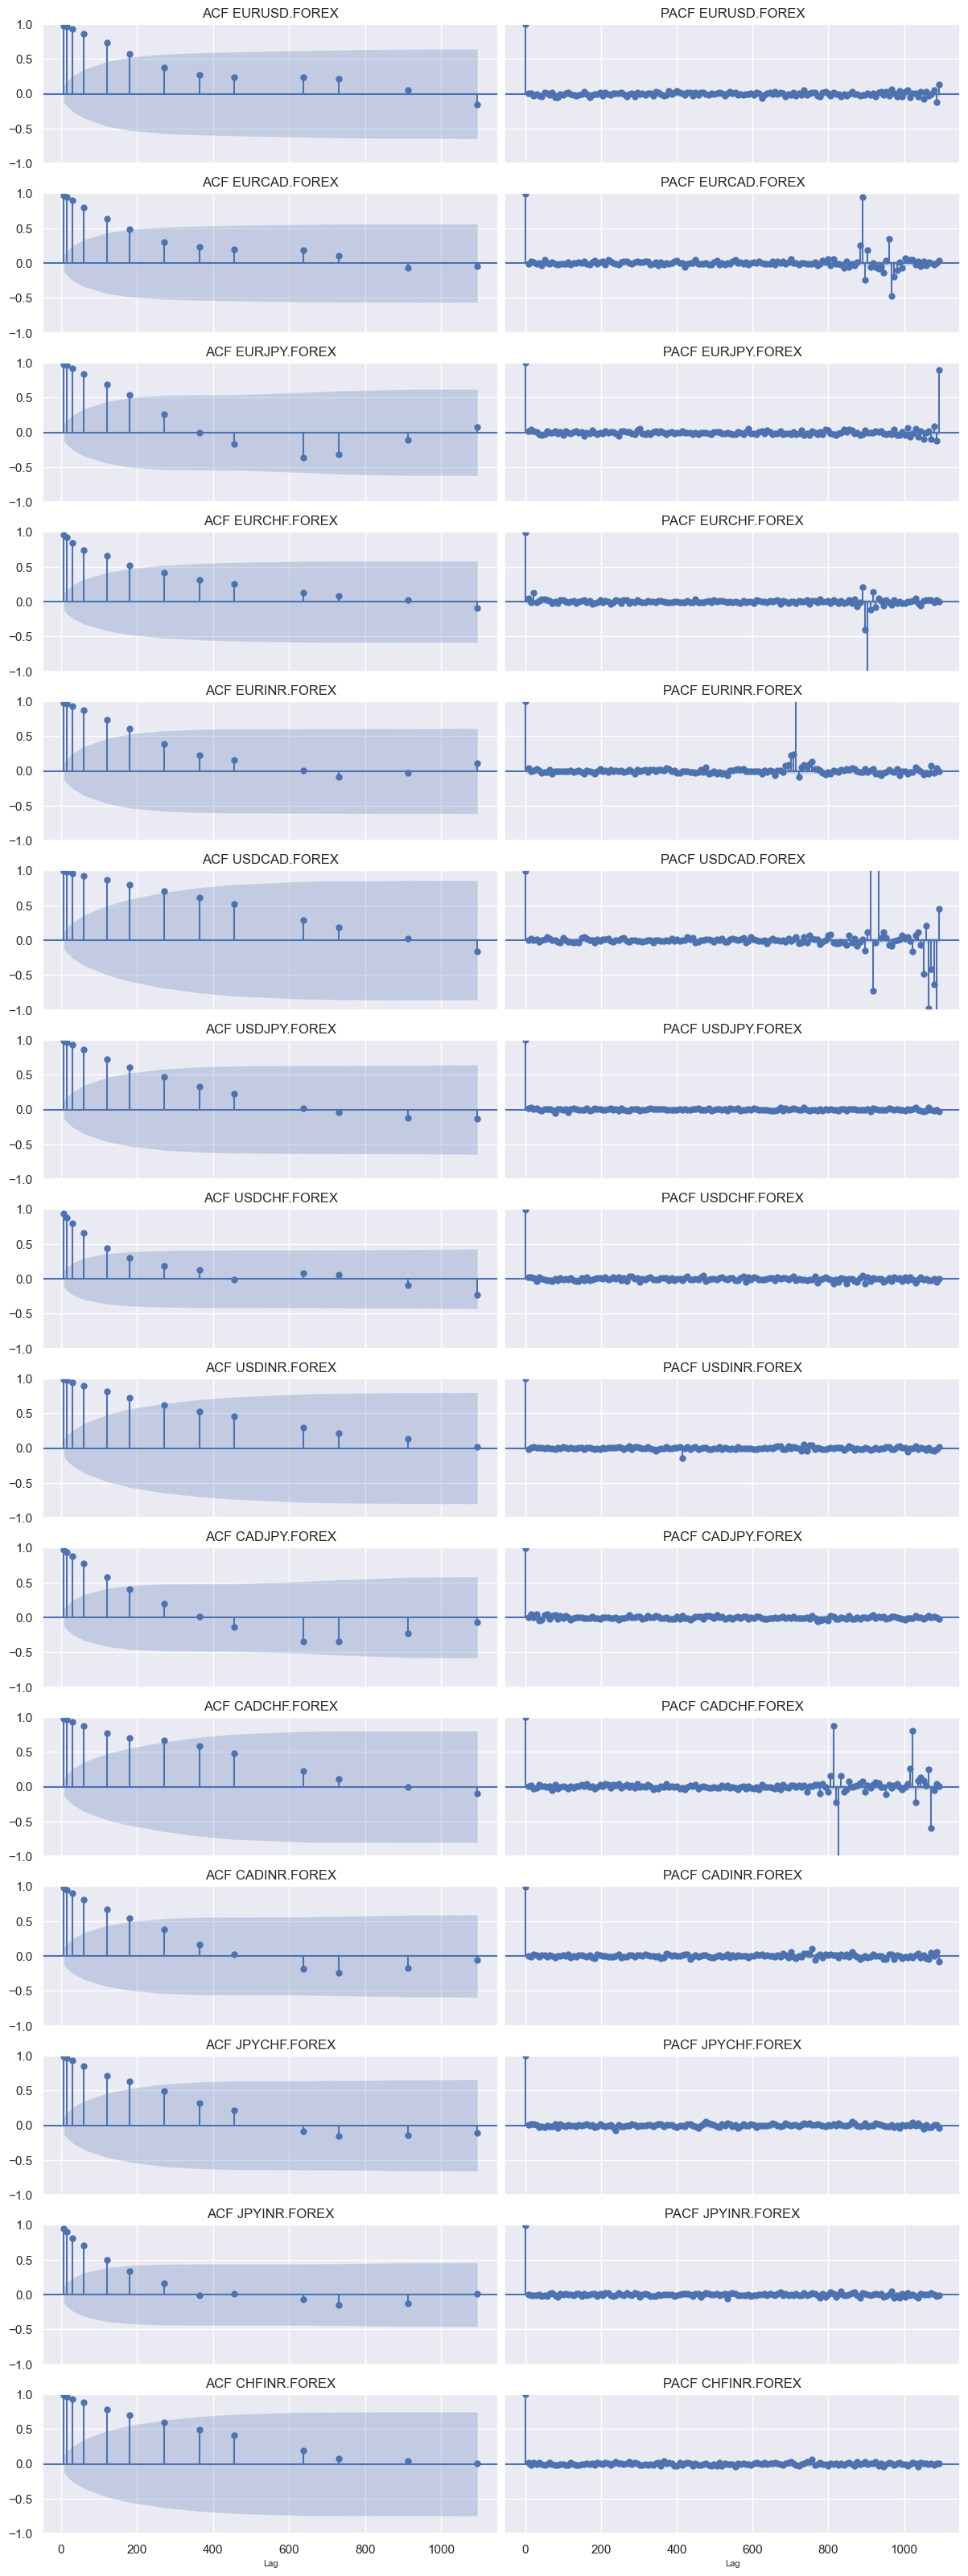

In [32]:
fig, axs = plt.subplots(len(tickers),2,figsize=(12,32),sharex='col',sharey='row') #initialize & store handles
currs = tickers#[2:12] #selected currency pairs
# Define lags used - for ACF can use larger increments
lag_acf = [7,14,30,60,120,180,270,365,int(1.25*365),int(1.75*365),int(2*365),int(2.5*365),int(3*365)] #ACF lags, same as ADF & KPSS
lag_pacf = list(range(1,int(3*365),7)) #7-day increments for granularity for PACF lags
for t,ticker in enumerate(currs): 
    price = df_daily[(df_daily['Ticker']==ticker)]['close']
    #Plot ACF and PACF
    plot_acf(price,lags=lag_acf,ax=axs[t,0],title='ACF '+ticker)
    plot_pacf(price,lags=lag_pacf,ax=axs[t,1],title='PACF '+ticker)
#Add xlabels only on last plots
axs[t,0].set_xlabel('Lag',fontsize=8)
axs[t,1].set_xlabel('Lag',fontsize=8)
fig.tight_layout(pad=0.5) #inter-plot padding
plt.savefig(root_results+'\ACF_PACF.png', format='png', dpi=1600,bbox_inches='tight')

- ACF (autocorrelation function) = correlation coefficients with timeseries and its lagged values, at different lags. The shaded region shows the 95% confidence interval. 
- The PACF (partial autocorrelation function) = similar to ACF but only shows direct effects with intermediary effects removed (i.e., the correlations of the data are taken at the exact lag value).
- An auto-regressive model (AR) could be considered as the ACF drops gradually and PACF drops instantly, but only where PACF values actually arise above the central tendency of 0.
- A moving average model is not appropriate as both ACF and PACF don't decline gradually
- In cases where ACF and PACF drop instantly (i.e., no significant correlated lags) - time series will need to be made stationary or other models not requiring stationarity are needed. <br>
<br>
Lags over 2-years for CAD-CHF, USD-CAD, EUR-INR, EUR-CHF,EUR-JPY seem to show autocorrelations in the PACF plots. 
Source: https://towardsdatascience.com/time-series-from-scratch-autocorrelation-and-partial-autocorrelation-explained-1dd641e3076f

For VARMAX models, the ideal p,q will be: p= # significant lags in ACF, and q = # significant lags in PACF

# Machine Learning

Machine Learning will be carried out on 3 selected currency pairs **EUR-USD, EUR-JPY, and USD-JPY**, which exhibit high correlations with one-another and could be used to examine a trading strategy.

## General Train-Test-Holdout Split Setup

After observing other examples of stocks/forex & other timeseries forecasting examples, the test-train split is generally on the order 90-10 to 97-3. <br> 
<u> This approach with VARMAX and FB Prophet:</u> 
    <br>
Hold-out: 2022-08-01 to 2022-11-01 <br>
Testing: 2022-01-01 to 2022-08-01 <br>
Training: 2010-10-01 to 2022-08-01 <br>
Where time-series cross validation is done, training will be conducted for 1-year long folds between 2010-10-01 to 2021-01-01.

In [33]:
# Define the split dates
split1 = datetime.datetime.strptime('2022-08-01',"%Y-%m-%d")
split2 = datetime.datetime.strptime('2022-01-01',"%Y-%m-%d")
start_date = datetime.datetime.strptime('2010-11-02',"%Y-%m-%d") #move up first day to account for differenced first day of series

## Classical Multivariate Time Series Forecasting
## Vector Autoregressive Moving Average with eXogenous regressors model (VARMAX)

- combination of VAR (Vector Auto Regression) and VMA (Vector Moving Average)  and a generalized type of the ARMA model
- built for multivariate stationary data
- Parameter 'p' and 'q' control the different components in the model


### Differencing/Transformation 

Prepare multivariate series - Simple difference by getting the difference between entry i and i-1. Also check if taking the log can **stablize the time series** for use in the VARMAX model. Potentially if required take the log and then difference. <br>
Also, adding a column for the closing value shifted 7 days back. This will be explained later on in this section.

Choosing not to scale the data since all the additional financial indicators are already normalized

In [160]:
inds = ['close','rsi','adx','dmi','macd_norm','bbands_norm','sar_norm','ma_position','fastkline','fastdline','k_values','d_values','interest_ratio','CPI_ratio','Sentiment_norm']
df_daily_red = df_daily[['Ticker','date']+inds] #scale down daily df to what will actually be used in modelling
int_const = [] #initialize list to store constants for integration of differences series (as NaN rows will be dropped)
# Difference the close price only
for ticker in tickers: #run by ticker to avoid differencing and shifting incorrectly
    for i in ['close']: #for each target column
        df_daily_red.loc[df_daily_red['Ticker']==ticker,i+'_dif'] = df_daily_red.loc[df_daily_red['Ticker']==ticker,i].diff() #differencing to previous day, rather than seasonality-based
        df_daily_red.loc[df_daily_red['Ticker']==ticker,i+'_log'] = df_daily_red.loc[df_daily_red['Ticker']==ticker,i].apply(np.log) #see if taking the log instead of differencing can be used
        df_daily_red.loc[df_daily_red['Ticker']==ticker,i+'+7d'] = df_daily_red.loc[df_daily_red['Ticker']==ticker,i].shift(-7)  # Shift back closing price by 7 trading days
        df_daily_red.loc[df_daily_red['Ticker']==ticker,i+'+7d_dif'] = df_daily_red.loc[df_daily_red['Ticker']==ticker,i+'+7d'].diff()
    df_daily_red[df_daily_red['Ticker']==ticker] = df_daily_red[df_daily_red['Ticker']==ticker].dropna() #drop null values
    #Resample so that every day has a value, buy forward filling the most recent val
    df_daily_red[df_daily_red['Ticker']==ticker] = df_daily_red[df_daily_red['Ticker']==ticker].resample('1D').ffill()

In [47]:
fid=r'\DailyForex_Indicators_Reduced.h5'
hdf = pd.HDFStore(root_results+fid) #initialize access to the db
# Append to table if appendh5=True; required for doing 1min increments and breaking calls up by month
df_daily_red.to_hdf(hdf,key='/main',format='table',append=False) 
hdf.close()

In [48]:
# Save to pickle for skforecast notebook
fid=r'\DailyForex_Indicators_Reduced.pkl'
df_daily_red.to_pickle(root_results+fid)

Isolate for the selected currency pairs being examined.

In [161]:
currs = ['EURUSD.FOREX','EURJPY.FOREX','USDJPY.FOREX'] #selected currency pairs
df_daily_3 = df_daily_red[df_daily_red['Ticker'].isin(currs)] #narrow-down the df

Check ACF & PACF plots of first-differenced and log-difference close price & other variables to examine stationarity

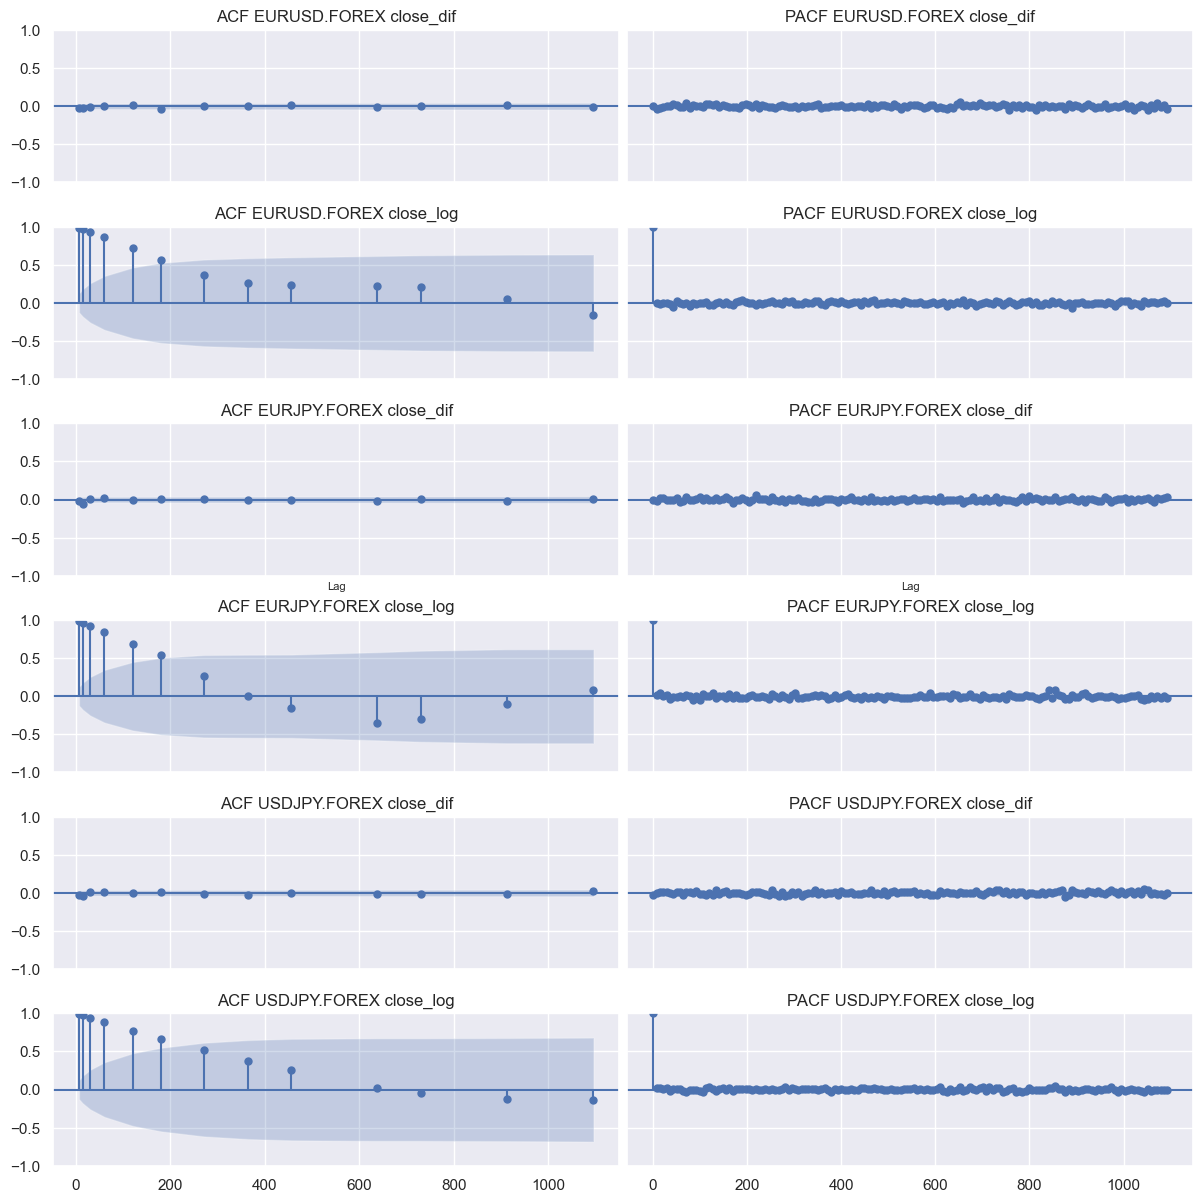

In [50]:
lag_acf = [7,14,30,60,120,180,270,365,int(1.25*365),int(1.75*365),int(2*365),int(2.5*365),int(3*365)] #ACF lags
lag_pacf = list(range(1,int(3*365),7)) #7-day increments for granularity for PACF lags
# Define lags used - for ACF can use larger increments
series = ['close_dif','close_log']
fig, axs = plt.subplots(len(currs)*len(series),2,figsize=(12,12),sharex='col',sharey='row') #initialize & store handles
count = 0 #initialize
for t,ticker in enumerate(currs):
    for s in series:
        y = df_daily_3[df_daily_3['Ticker']==ticker][s]
        #Plot ACF and PACF
        plot_acf(y,lags=lag_acf,ax=axs[count,0],title='ACF '+ticker+' '+s)
        plot_pacf(y,lags=lag_pacf,ax=axs[count,1],title='PACF '+ticker+' '+s)
        count += 1 #row counter
#Add xlabels only on last plots
axs[t,0].set_xlabel('Lag',fontsize=8)
axs[t,1].set_xlabel('Lag',fontsize=8)
fig.tight_layout(pad=0.5) #inter-plot padding
plt.savefig(root_results+'\ACF_PACF_EURUSDJPY_diff.png', format='png', dpi=1600,bbox_inches='tight')

From the ACF plots above, the close price can be made stationary with first difference but not the log.

### Correlation and Cointegration of Exgogenous Variables & Target

Correlations between factors do not mean cointegration. <br>
Cointegration = variables that 'move' together through time forming a long-term relationship, despite being individuall non-stationary; However they could be exhibiting differing dynamic properties in the short-run

In [112]:
df = df_daily_3[['Ticker','close','rsi','adx','dmi','macd_norm','bbands_norm','sar_norm','k_values','d_values','Sentiment_norm']] #isolate selected vars
df.loc[df['Ticker']=='EURUSD.FOREX','close']= df[df['Ticker']=='EURUSD.FOREX']['close'].multiply(100) # by 100 to match order of magnitude of other two just for display

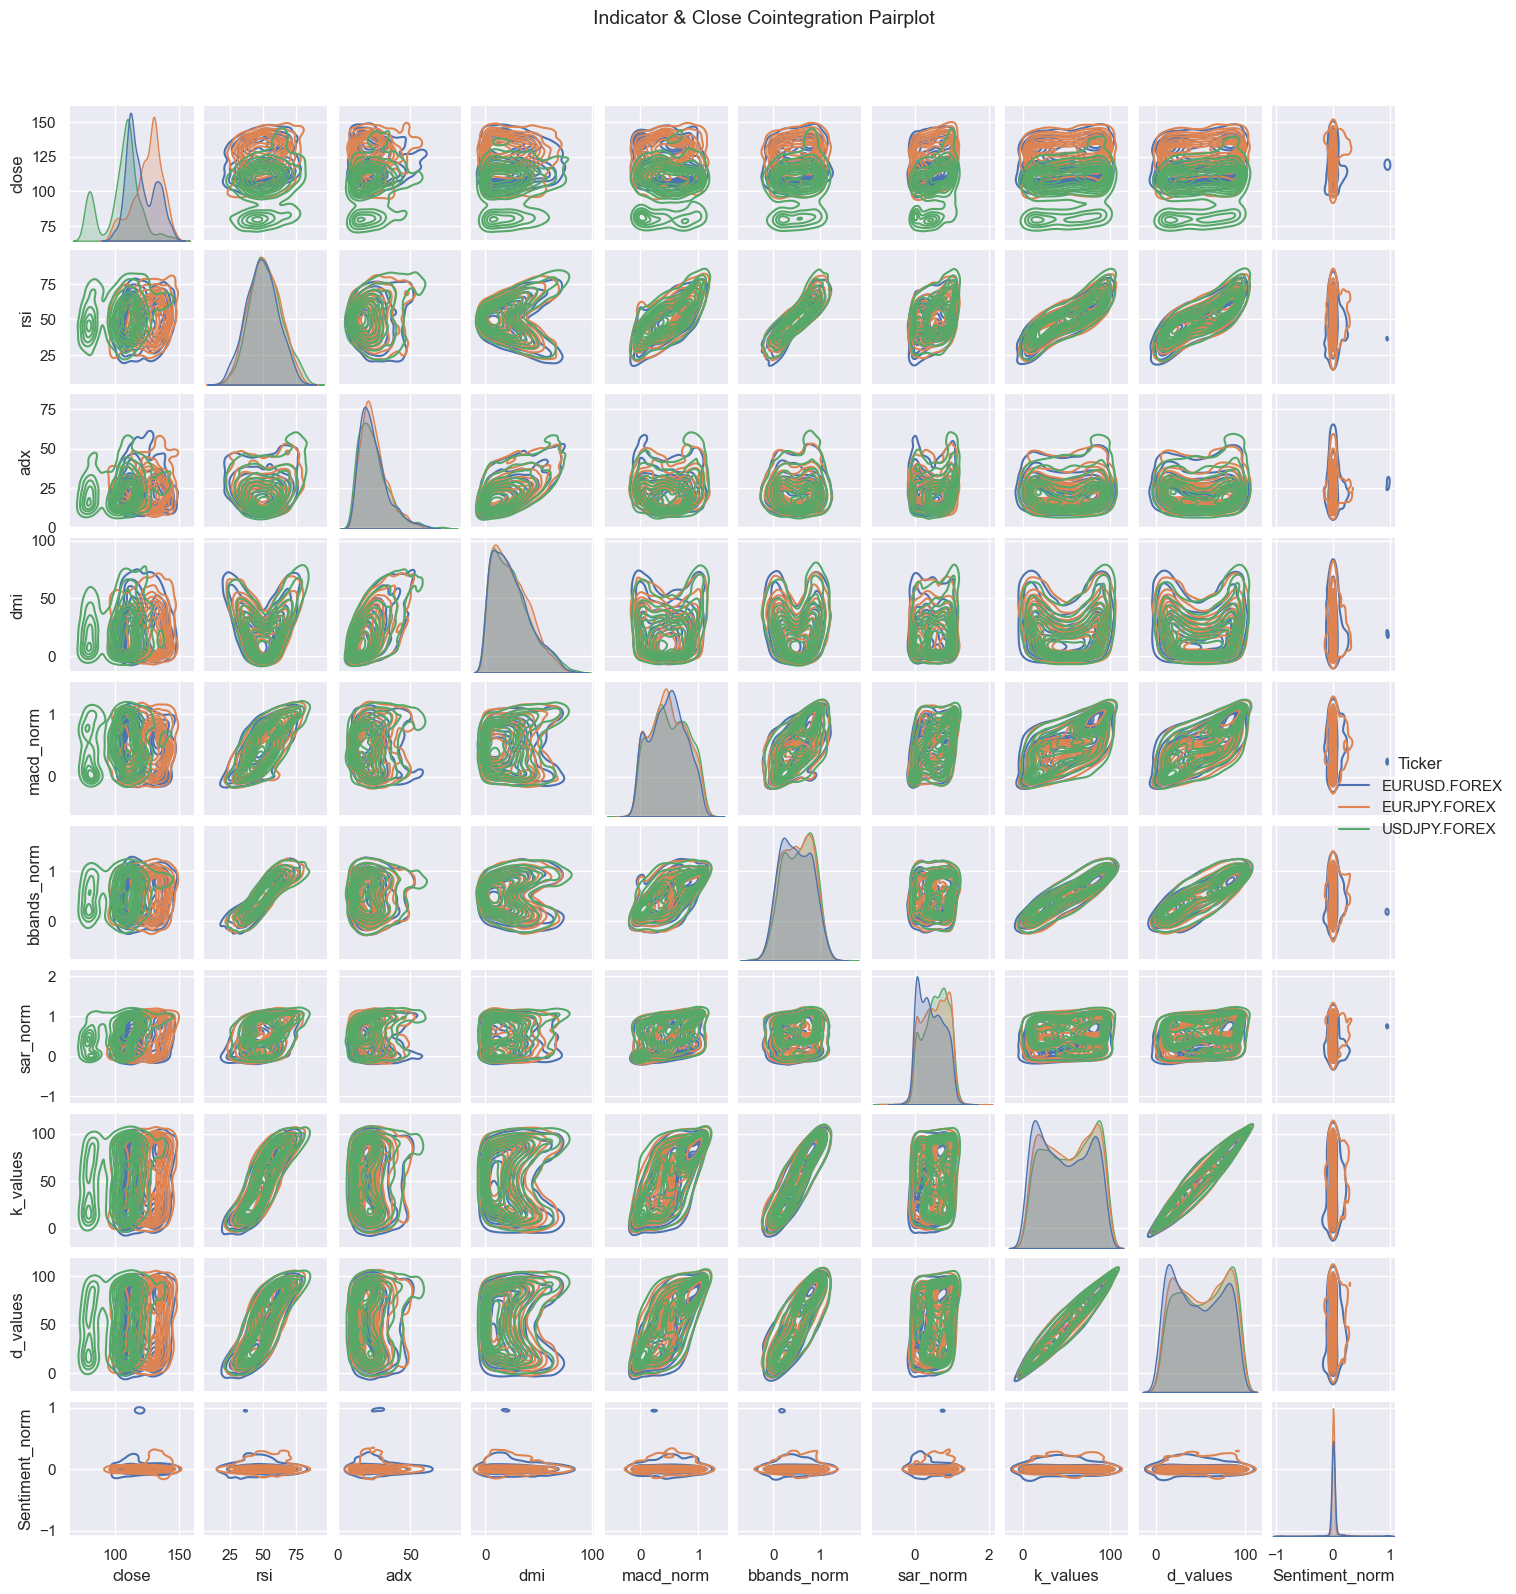

In [115]:
g =  sns.pairplot(df,hue='Ticker',kind='kde')
g.fig.suptitle('Indicator & Close Cointegration Pairplot', x =0.5, y=1.05, fontsize=14)
g.fig.set_size_inches(15,15)
plt.savefig(root_results+'\Pairplot.png', format='png', dpi=1200,bbox_inches='tight')

Check for cointegration of variables

In [55]:
def find_cointegratration(df):
    '''
    Takes a df and runs cointegration test between each feature pair
    INput: data frame with numeric features only - time series
    Outputs cointegration score matrix, p-value matrix, and cointegrated pairs
    '''
    n = df.shape[1] #number of features
    # initialize
    score_matrix = np.zeros((n, n)) 
    pvalue_matrix = np.ones((n, n))
    pairs = []
    keys = df.keys() #get the feature names
    # for every feature pair - run cointegration test
    for i in range(n):
        for j in range(i+1, n):
            # Get series of 2 features for coint test
            S1 = df[keys[i]]
            S2 = df[keys[j]] 
            # Stats model cointegration, extract results
            result = coint(S1, S2, maxlag=1) #statsmodels coint
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            # when p-val <0.05, null hypothesis not rejected i.e., pair is cointegrated
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

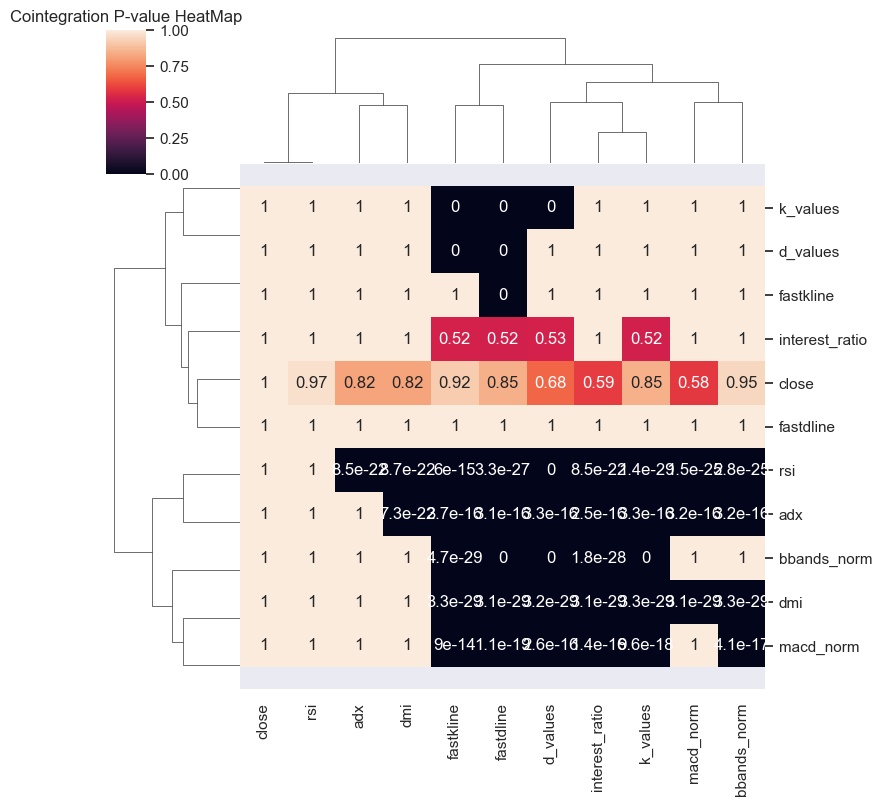

In [56]:
# Test for Cointegration
df = df_daily_3[df_daily_3['Ticker']==currs[0]][['close','rsi','adx','dmi','macd_norm','bbands_norm','interest_ratio','k_values','d_values','fastkline','fastdline']] #check EURUSD only
#df_coint = cointegration_test(df) #all parameters except 'date' and 'Ticker'
scores, pvalue_matrix, pairs = find_cointegratration(df)
coint_pvalue_matrix_df = pd.DataFrame(pvalue_matrix)
# Plot clustermap showing the p-values, <.05 means coinintegrated
g = sns.clustermap(coint_pvalue_matrix_df, xticklabels=df.columns,yticklabels=df.columns, annot=True, 
                   figsize=(8, 8))
plt.title('Cointegration P-value HeatMap')
ax = g.ax_heatmap
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()
plt.savefig(root_results+'\Cointegration.png', format='png', dpi=1200,bbox_inches='tight')

In [57]:
# Show cointegrated pairs
pairs

[('rsi', 'adx'),
 ('rsi', 'dmi'),
 ('rsi', 'macd_norm'),
 ('rsi', 'bbands_norm'),
 ('rsi', 'interest_ratio'),
 ('rsi', 'k_values'),
 ('rsi', 'd_values'),
 ('rsi', 'fastkline'),
 ('rsi', 'fastdline'),
 ('adx', 'dmi'),
 ('adx', 'macd_norm'),
 ('adx', 'bbands_norm'),
 ('adx', 'interest_ratio'),
 ('adx', 'k_values'),
 ('adx', 'd_values'),
 ('adx', 'fastkline'),
 ('adx', 'fastdline'),
 ('dmi', 'macd_norm'),
 ('dmi', 'bbands_norm'),
 ('dmi', 'interest_ratio'),
 ('dmi', 'k_values'),
 ('dmi', 'd_values'),
 ('dmi', 'fastkline'),
 ('dmi', 'fastdline'),
 ('macd_norm', 'bbands_norm'),
 ('macd_norm', 'interest_ratio'),
 ('macd_norm', 'k_values'),
 ('macd_norm', 'd_values'),
 ('macd_norm', 'fastkline'),
 ('macd_norm', 'fastdline'),
 ('bbands_norm', 'interest_ratio'),
 ('bbands_norm', 'k_values'),
 ('bbands_norm', 'd_values'),
 ('bbands_norm', 'fastkline'),
 ('bbands_norm', 'fastdline'),
 ('k_values', 'd_values'),
 ('k_values', 'fastkline'),
 ('k_values', 'fastdline'),
 ('d_values', 'fastkline'),
 ('

statsmodels.coint() test:
    Ho = no cointegration, H1 = cointegration present. Variables in y0 and y1 are assumed to be integrated of order 1, I(1). Uses Engle-Granger two-step cointegration test. Constant or trend is included in 1st stage regression, i.e. in cointegrating equation.



The selected features (except d_values) do not appear to be cointegrated with the close values. Two tests can be performed: <br>
SELECTED APPROACH =  Treat the technical indicators as exogenous features, i.e. supplied to the model as independent variables during prediction. <br> 
<br>
However, if we have an ML FOREX model, it would be ideal to take the technical indicators on a given day (and their time histories) and predict the closing exchange rate in about a week. To do this  backward 7-day shift  will be created for the close price. <br>

In [68]:
# Exogenous features available for model - only select technical indicators
exog_feats = ['rsi','adx','dmi','macd_norm','bbands_norm','sar_norm','k_values','d_values']

### Auto_Arima

First try auto_arima to see if it can select the AR(p) MA(q) and differencing (d) 

Parameters: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html <br>
- p = number of lag observations in the model = lag order
- q = size of moving average window, order of moving average
- start_q & start_p = 0, get full range of possibilities (default = 2)
- max_p,max_d,max_q default = 5
- d=None - order of first-differencing (default is None)
- Trace = True, for printing progress
- max_P and max_Q and D, start_P, start_Q are seasonal hyperparameters - not necessary, leave as default
- stationary = False (default) - if True then d should be 0

In [101]:
exog_feats

['rsi',
 'adx',
 'dmi',
 'macd_norm',
 'bbands_norm',
 'sar_norm',
 'k_values',
 'd_values']

In [91]:
train = df_daily_3[(df_daily_3['Ticker']==currs[0])&(df_daily_3.index <split2)]
model = auto_arima(train[train['Ticker']==currs[0]]['close'], exogenous=train[exog_feats], stationary = False,
                   seasonal = True,  method = 'bfgs', solver = 'bfgs',start_p=1,start_q=1,
                   trace=True, error_action="ignore", suppress_warnings=True,n_job=-1)
#no seasonal effect assumed

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-21551.379, Time=1.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21555.346, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21553.379, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-21553.379, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21556.879, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.399 seconds


In [83]:
model.fit(train[train['Ticker']==currs[0]].index)

In [99]:
test = df_daily_3[(df_daily_3['Ticker']==currs[0])&(df_daily_3.index >=split2)] #lump all values for testing after 2022-01-01
forecast = pd.DataFrame(model.predict(periods=len(test)),columns=['prediction'])

In [100]:
forecast #strange result - leave this behind

prediction
2948       1.137
2949       1.137
2950       1.137
2951       1.137
2952       1.137
2953       1.137
2954       1.137
2955       1.137
2956       1.137
2957       1.137

This gives a strange results where, where the p and q terms are set to zero. Fitting the model gave a flat line (constant) prediction. Try building VARMAX model from scratch.

### VARMAX by StatsModels

Define VARMAX function - use for gridsearch of best AR(p), MA(q) and trend (tr) parameters to use

In [153]:
def varmax_multi(tickers,param_grid,df_in,tt_split,exog,endog,endog_dif=[False,False],save_pred=False):
    '''
    Inputs:
        tickers = string list containing the tickers symbols for which the model is fit
        param_grid = list of dictionaries - each containing input p,q,and tr for VARMAX model in form 
            [{'p':int,'q':int,'tr':str},{....},..] where tr can be 'n','c','t','ct'
        df_in = full input dataframe with information for all tickers, index must be datetime64 index and no missing days
        tt_split = test-train split date aas string
        endog dif = boolean list = flag for endog variables being difference already or not
        exog = string list containing the column names of exogenous variables
        endog = string list containing the column names of endogenous variables (ONLY SETUP FOR 2)
        save_pred = bool; if True will save the predicted endogenous results for the full dataset
    Returns:
        varmax = nested dictionary containing df's: df of evaluation metrics for each ticker summarizing 
            p,q,tr results accessed by varmax[ticker]['eval']; and if save_pred is True, df of prediction results 
            for each model run accessed by varmax[ticker]['preds']['p'+str(p)+'q'+str(q)+'tr'+str(tr)]
    '''
    varmax_eval = {} #initialize empty dict where eval metrics will be saved
    varmax_pred = {} #initialize empty dict where predictions can be saved
    for ticker in tickers: # for each ticker
        varmax_pred[ticker] = {} #initialize nested dict
        # Get data for ticker - test/train split
        splitdate = datetime.datetime.strptime(tt_split,"%Y-%m-%d")
        startdate = df_in[df_in['Ticker']==ticker].index[0] #first day
        if True in endog_dif: #if any endog vars are differenced:
            start_date = df_in[df_in['Ticker']==ticker].index[1] #offset one day as constant term needed for first reverse difference (integration)
        full = df_in[(df_in['Ticker']==ticker)&(df_in.index >=startdate)] #full dataset
        test = df_in[(df_in.index>=splitdate)&(df_in['Ticker']==ticker)]  #test dataset
        train = df_in[(df_in.index >=startdate)&(df_in.index <splitdate)&(df_in['Ticker']==ticker)] #train dataset

        # Initialize df where grid search parameters will be stores
        df_varmax_search = pd.DataFrame(columns=['p', 'q', 'tr','RMSE_'+endog[0],'MAE_'+endog[0],'R2_'+endog[0],
                                                 'RMSE_'+endog[1],'MAE_'+endog[1],'R2_'+endog[1]])
        # Iteratate through each input parameter grid element (p,q,tr)
        for p,params in enumerate(param_grid):
            # Extract ARMA & trend parameters
            p = params.get('p') #AR (auto-regressive) order
            q = params.get('q') #MA (moving average) order
            tr = params.get('tr') #trend polynomial parameter
            # VARMAX gridsearch for each p,q and trend type - y = differenced close values
            # ...VARMAX requires 2 endog variables, use original undifferenced close price
            model = VARMAX(train[endog],exog=train[exog], order=(p,q), trend=tr).fit() #fit the model
            result = model.predict(start=train.index[0],end=train.shape[0]+test.shape[0]-1,
                                   exog=test[exog],dynamic=True) #dynamic endogeous predictions used (both closing value)
            CI = model.get_prediction(start=train.index[0],end=train.shape[0]+test.shape[0]-1,
                                   exog=test[exog],dynamic=True).conf_int(alpha=0.05) #get confidence intervals
            result.columns = [c+'_pred' for c in endog] #change the column labels adding suffix
            result = result.set_index(full.index) #set the index to match the full actual series
            CI.columns = [c+'_pred_'+lh for c in endog for lh in ['lower','upper']] #change the column labels adding suffix
            CI = CI.set_index(full.index) #set the index to match the full actual series
            result = pd.concat([result,CI],axis=1)
            # Predictions df
            df_preds = pd.concat([full,result],axis=1) #concatenate input full dataset to with the predicted results (raw)
            # Initialize
            inverse = {} #ict for inverses (if needed)
            mae = [] # evaluation metrics
            rmse = [] 
            r2 = []
            # Inverse differencing & evaluatin metrics per endog var
            for e,endog_ in enumerate(endog):
                # Apply inverse difference (integration) to endog variables if differenced vars were input
                if endog_dif[e] == True: #if any endog vars are differenced:
                    int_const = df_in.loc[df_in['Ticker']==ticker,endog_.replace('_dif','')][0] #constant for inverse diff - get first value of input series (undifference)
                    for iv in ['_pred','_pred_lower','_pred_upper']:
                        inverse = utils.diff_inv(result[endog_+iv]) + int_const #integrate and add back constant
                        inverse = np.delete(inverse, 1, 0) #delete the padded 0 at the front
                        pred_col = endog_+iv+'_inv' # name of predicted column
                        df_preds[pred_col] = inverse.tolist() #append another column with the inverse predictions
                else:
                    pred_col = endog_+'_pred' #else column for eval metrics is raw predicted from model
                # Evaluation metrics
                mae.append(MAE(df_preds[endog_],df_preds[pred_col])) #MAE                    
                r2.append(r2_score(df_preds[endog_],df_preds[pred_col])) #R2               
                rmse.append(np.sqrt(MSE(df_preds[endog_],df_preds[pred_col]))) #RMSE

            # Create/Append to results df
            df_varmax_search = df_varmax_search.append({'p': p, 'q': q, 'tr': tr,
                                                        'RMSE_'+endog[0]:rmse[0],'MAE_'+endog[0]:mae[0],'R2_'+endog[0]:r2[0],
                                                        'RMSE_'+endog[1]:rmse[1],'MAE_'+endog[1]:mae[1],'R2_'+endog[1]:r2[1]}, 
                                                       ignore_index=True)
            if save_pred == True: # Only save prediction results for each parameter grid element if specified
                varmax_pred[ticker]['p'+str(p)+'q'+str(q)+'tr'+str(tr)] = df_preds # Store the predictions df
        # Store model parameter and evaluation metrics always
        varmax_eval[ticker] = df_varmax_search
        
    return varmax_pred, varmax_eval

In [181]:
param_iter = {'p': [1,2,3], 'q':[0,1,2,3], 'tr': ['n','c','t','ct',[1,1,0,1],[1,1,1,1],[0,1,1,1],[0,0,1,1]]}
param_grid = list(sklearn.model_selection.ParameterGrid(param_iter)) #use sklearn ParameterGrid to generate discrete values for each parameter

In [182]:
# Run the two selected models
exog_vars = ['rsi','dmi','macd_norm'] #exogenous variables (independent vars)
endog_vars = ['close','close+7d'] #endogenous variables (dependent vars)
select_params = param_grid #selected VARMAX model order & trend from prelim analysis
int_const = df_daily_red.loc[df_daily_red['Ticker']==ticker,'close+7d'][0]
varmax_grid_pred, varmax_grid = varmax_multi(tickers=[currs[0]],param_grid=select_params,df_in=df_daily_3,
                                             tt_split='2022-08-01',
                                            exog=exog_vars,endog=endog_vars,endog_dif=[False,False],save_pred=True)

In [185]:
df_varmax_grid = varmax_grid[currs[0]]

#### Sort for the results of the inverse differenced close+7days series

**NOTE** Initially using the differenced +7day time series but it gave nonsensical results. AS such this section does not use differenced series any longer.

In [186]:
df_varmax_grid.sort_values('MAE_close+7d').head(3)

p  q  tr  RMSE_close  MAE_close  R2_close  RMSE_close+7d  MAE_close+7d  \
67  3  0  ct       0.071      0.057     0.597          0.070         0.057   
75  3  1  ct       0.071      0.057     0.597          0.070         0.057   
83  3  2  ct       0.071      0.057     0.597          0.070         0.057   

    R2_close+7d  
67        0.600  
75        0.600  
83        0.600

In [187]:
df_varmax_grid.sort_values('R2_close+7d',ascending=False).head(3)

p  q  tr  RMSE_close  MAE_close  R2_close  RMSE_close+7d  MAE_close+7d  \
91  3  3  ct       0.071      0.057     0.598          0.070         0.057   
83  3  2  ct       0.071      0.057     0.597          0.070         0.057   
75  3  1  ct       0.071      0.057     0.597          0.070         0.057   

    R2_close+7d  
91        0.600  
83        0.600  
75        0.600

Model with (p,q,tr) = (3,3,'ct') has the best R2

Model with (p,q,tr) = (3,3,'ct') has the best R2 and MAE

In [210]:
# Run the two selected models
exog_vars = ['rsi','dmi','macd_norm'] #exogenous variables (independent vars)
endog_vars = ['close','close+7d'] #endogenous variables (dependent vars)
select_params = [{'p':3,'q':3,'tr':'ct'},{'p':3,'q':2,'tr':'ct'}] #selected VARMAX model order & trend from prelim analysis
int_const = df_daily_red.loc[df_daily_red['Ticker']==ticker,'close+7d'][0]
varmax_pred, varmax_eval = varmax_multi(tickers=[currs[0]],param_grid=select_params,df_in=df_daily_3,tt_split='2022-08-01',
                            exog=exog_vars,endog=endog_vars,endog_dif=[False,True],save_pred=True)

In [211]:
# Examine evaluation metrics again for the two chosen models - just for one currency pair
varmax_eval[currs[0]]

p  q  tr  RMSE_close  MAE_close  R2_close  RMSE_close+7d  MAE_close+7d  \
0  3  3  ct       0.071      0.057     0.598       2526.289      2210.874   
1  3  2  ct       0.071      0.057     0.597       2534.037      2217.661   

     R2_close+7d  
0 -515868972.710  
1 -519037956.497

In [212]:
model1 = varmax_pred[currs[0]]['p3q2trct']
model2 = varmax_pred[currs[0]]['p3q3trct']

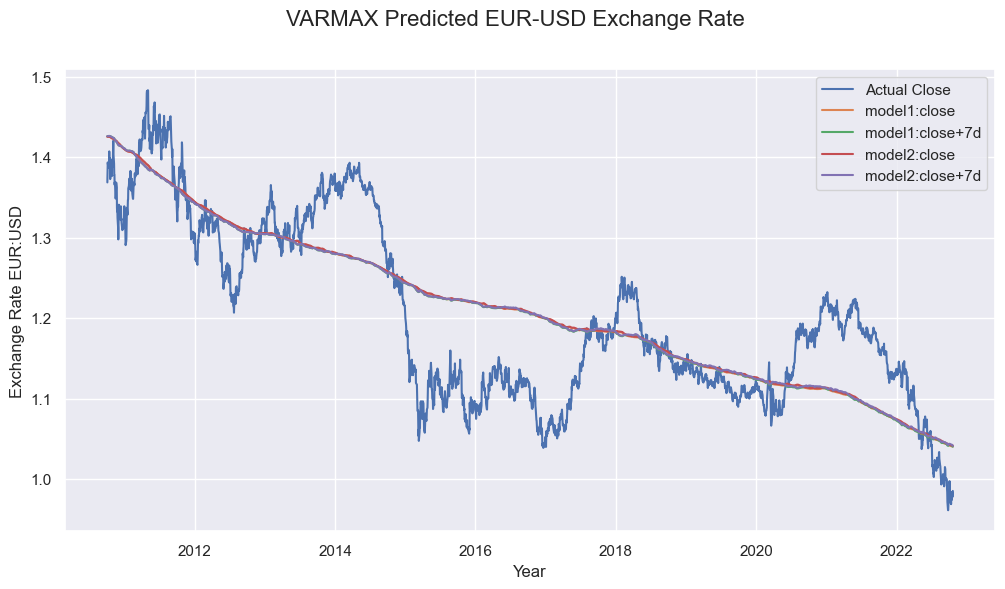

In [214]:
fig, ax = plt.subplots(figsize = (12,6))
plt.plot(df_daily_3[df_daily_3['Ticker']==currs[0]]['close'],label='Actual Close')
plt.plot(model1['close_pred'],label='model1:close') #
plt.plot(model1['close+7d_pred'],label='model1:close+7d')
plt.plot(model2['close_pred'],label='model2:close') #
plt.plot(model2['close+7d_pred'],label='model2:close+7d')
plt.legend()
fig.suptitle('VARMAX Predicted EUR-USD Exchange Rate',fontsize=16) #main title slight elevated above subplots
ax.set_xlabel('Year',fontsize=12)
ax.set_ylabel('Exchange Rate EUR:USD',fontsize=12)
plt.savefig(root_results+'\VARMAX.png', format='png', dpi=600,bbox_inches='tight')

## Facebook Prophet

Facebook Prophet was specifically designed for business time-series forceasting. There are numerous examples in the literature of it's use for stocks/forex. It requires less hyperparameter tuning. It will be used for a baseline in simply predicting stock price from past data.

In [193]:
exog_vars = ['rsi','dmi','macd_norm'] #exogenous variables (independent vars) - limited set

In [194]:
exog_test_fb = test[exog_vars]
exog_train_fb = train[exog_vars]

In [195]:
test_fb = test[['date','close+7d']+exog_vars]
train_fb = train[['date','close+7d']+exog_vars]

In [196]:
# Change the column names in accordance with Prophet requirements
#holdout_fb.columns=['ds','y']
test_fb.columns = ['ds','y','exog1','exog2','exog3']
X_test_fb = test_fb[['ds','exog1','exog2','exog3']] # only the dates and exog
train_fb.columns = ['ds','y','exog1','exog2','exog3']

In [197]:
# Baseline Model - hyperparameters set to default except for:
# only expecting yearly seasonlity based on the seasonal decomposition above
prophet_baseline = Prophet(yearly_seasonality=True,weekly_seasonality=False,daily_seasonality=False,
                           seasonality_mode='multiplicative')
# Add exogenous variables as additional regressors
prophet_baseline.add_regressor('exog1')
prophet_baseline.add_regressor('exog2')
prophet_baseline.add_regressor('exog3')

In [198]:
# The the model
fit = prophet_baseline.fit(train_fb)

03:22:09 - cmdstanpy - INFO - Chain [1] start processing
03:22:12 - cmdstanpy - INFO - Chain [1] done processing


In [199]:
# Predict with date and exog vars for test set
forecast_baseline = prophet_baseline.predict(X_test_fb)

In [200]:
forecast_baseline

ds  trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2022-01-03  1.204       1.163       1.215        1.204        1.204   
1   2022-01-04  1.204       1.162       1.217        1.204        1.204   
2   2022-01-05  1.204       1.168       1.224        1.204        1.204   
3   2022-01-06  1.205       1.165       1.220        1.205        1.205   
4   2022-01-07  1.205       1.174       1.228        1.205        1.205   
..         ...    ...         ...         ...          ...          ...   
225 2022-10-17  1.238       1.148       1.339        1.142        1.332   
226 2022-10-18  1.238       1.146       1.340        1.142        1.333   
227 2022-10-19  1.238       1.137       1.337        1.142        1.334   
228 2022-10-20  1.238       1.140       1.335        1.141        1.334   
229 2022-10-21  1.238       1.146       1.344        1.140        1.335   

     exog1  exog1_lower  exog1_upper  exog2  exog2_lower  exog2_upper  exog3  \
0   -0.003       -0.003       -0.003  0.002        0.002        0.002 -0.003   
1   -0.004       -0.004       -0.004  0.002        0.002        0.002 -0.003   
2    0.000        0.000        0.000  0.003        0.003        0.003 -0.003   
3   -0.003       -0.003       -0.003  0.003        0.003        0.003 -0.003   
4    0.006        0.006        0.006  0.001        0.001        0.001 -0.003   
..     ...          ...          ...    ...          ...          ...    ...   
225  0.003        0.003        0.003  0.000        0.000        0.000 -0.002   
226  0.004        0.004        0.004  0.000        0.000        0.000 -0.003   
227 -0.002       -0.002       -0.002  0.001        0.001        0.001 -0.003   
228 -0.001       -0.001       -0.001  0.001        0.001        0.001 -0.003   
229  0.004        0.004        0.004  0.002        0.002        0.002 -0.004   

     exog3_lower  exog3_upper  extra_regressors_multiplicative  \
0         -0.003       -0.003                           -0.004   
1         -0.003       -0.003                           -0.005   
2         -0.003       -0.003                           -0.001   
3         -0.003       -0.003                           -0.003   
4         -0.003       -0.003                            0.004   
..           ...          ...                              ...   
225       -0.002       -0.002                            0.002   
226       -0.003       -0.003                            0.001   
227       -0.003       -0.003                           -0.004   
228       -0.003       -0.003                           -0.003   
229       -0.004       -0.004                            0.003   

     extra_regressors_multiplicative_lower  \
0                                   -0.004   
1                                   -0.005   
2                                   -0.001   
3                                   -0.003   
4                                    0.004   
..                                     ...   
225                                  0.002   
226                                  0.001   
227                                 -0.004   
228                                 -0.003   
229                                  0.003   

     extra_regressors_multiplicative_upper  multiplicative_terms  \
0                                   -0.004                -0.013   
1                                   -0.005                -0.014   
2                                   -0.001                -0.008   
3                                   -0.003                -0.010   
4                                    0.004                -0.002   
..                                     ...                   ...   
225                                  0.002                 0.005   
226                                  0.001                 0.003   
227                                 -0.004                -0.002   
228                                 -0.003                -0.001   
229                                  0.003              

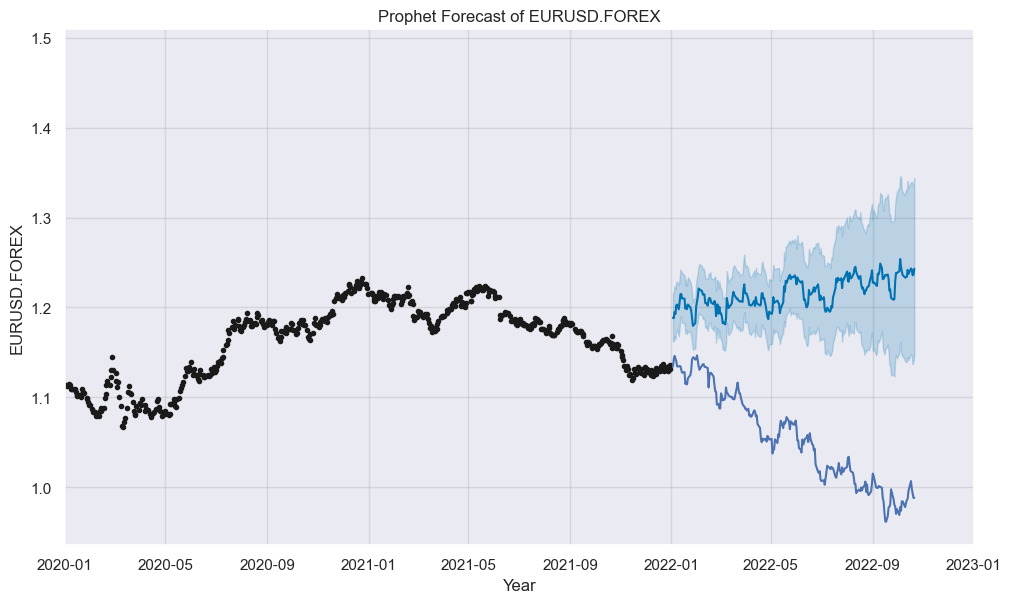

In [217]:
fig = prophet_baseline.plot(forecast_baseline,uncertainty=True,xlabel='Year',ylabel=currs[0]);
ax = fig.gca()
ax.tick_params()
ax.set_title("Prophet Forecast of "+currs[0])
lowerbound =  datetime.datetime.strptime('2020-01-01',"%Y-%m-%d")
upperbound =  datetime.datetime.strptime('2023-01-01',"%Y-%m-%d")
ax.set_xlim([lowerbound,upperbound])
ax.plot(test_fb['ds'],test_fb['y'],label='actual')

The result seems strange, even after trying other exchange rate pairs. It could be because the seaonality effect is not proncounced enough for the model to make predictions accurately.

In [202]:
# Create df with actual and predicted values
performance_baseline = pd.merge(test_fb, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
# Check MAE value
performance_baseline_MAE = MAE(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')
# Check r2 value
performance_baseline_MAPE = r2_score(performance_baseline['y'], performance_baseline['yhat'])
print(f'The R2 for the baseline model is {performance_baseline_MAPE}')

The MAE for the baseline model is 0.16090585020144124
The R2 for the baseline model is -10.141015123971066


In [203]:
df_cv = cross_validation(prophet_baseline, initial='730 days', period='180 days', horizon = '365 days')

  0%|          | 0/17 [00:00<?, ?it/s]

03:22:14 - cmdstanpy - INFO - Chain [1] start processing
03:22:14 - cmdstanpy - INFO - Chain [1] done processing
03:22:15 - cmdstanpy - INFO - Chain [1] start processing
03:22:15 - cmdstanpy - INFO - Chain [1] done processing
03:22:16 - cmdstanpy - INFO - Chain [1] start processing
03:22:16 - cmdstanpy - INFO - Chain [1] done processing
03:22:20 - cmdstanpy - INFO - Chain [1] start processing
03:22:21 - cmdstanpy - INFO - Chain [1] done processing
03:22:22 - cmdstanpy - INFO - Chain [1] start processing
03:22:23 - cmdstanpy - INFO - Chain [1] done processing
03:22:24 - cmdstanpy - INFO - Chain [1] start processing
03:22:25 - cmdstanpy - INFO - Chain [1] done processing
03:22:26 - cmdstanpy - INFO - Chain [1] start processing
03:22:27 - cmdstanpy - INFO - Chain [1] done processing
03:22:28 - cmdstanpy - INFO - Chain [1] start processing
03:22:30 - cmdstanpy - INFO - Chain [1] done processing
03:22:31 - cmdstanpy - INFO - Chain [1] start processing
03:22:32 - cmdstanpy - INFO - Chain [1]

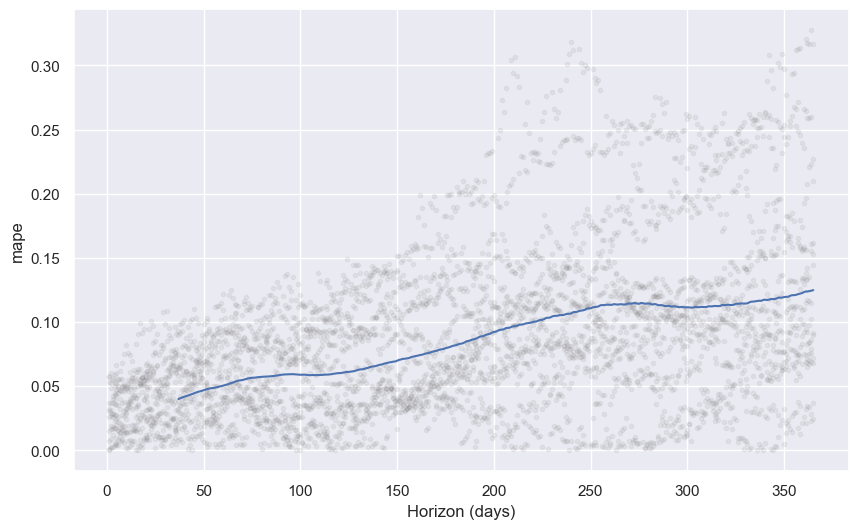

In [204]:
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.savefig(root_results+'\ProphetCV.png', format='png', dpi=1200,bbox_inches='tight')

In [205]:
df_p = performance_metrics(df_cv)
df_p.head()

horizon   mse  rmse   mae  mape  mdape  smape  coverage
0 37 days 0.003 0.055 0.047 0.040  0.039  0.040     0.183
1 38 days 0.003 0.056 0.048 0.041  0.040  0.041     0.177
2 39 days 0.003 0.056 0.049 0.041  0.041  0.041     0.178
3 40 days 0.003 0.057 0.049 0.042  0.041  0.042     0.177
4 41 days 0.003 0.058 0.050 0.042  0.041  0.042     0.173

In [206]:
# Generate parameter grid - only iterate on changepoint scale
import itertools
param_grid = {'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5]}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

In [207]:
# Use cross validation to evaluate all parameters
for params in all_params:
    model_fb_cv = Prophet(yearly_seasonality=True,weekly_seasonality=False,daily_seasonality=False,
                           seasonality_mode='multiplicative')
    # Add exogenous variables as additional regressors
    model_fb_cv.add_regressor('exog1')
    model_fb_cv.add_regressor('exog2')
    model_fb_cv.add_regressor('exog3')
    model_fb_cv_fit = model_fb_cv.fit(train_fb)
    df_cv = cross_validation(model_fb_cv_fit, horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

03:23:15 - cmdstanpy - INFO - Chain [1] start processing
03:23:19 - cmdstanpy - INFO - Chain [1] done processing
03:24:36 - cmdstanpy - INFO - Chain [1] start processing
03:24:39 - cmdstanpy - INFO - Chain [1] done processing
03:25:57 - cmdstanpy - INFO - Chain [1] start processing
03:26:01 - cmdstanpy - INFO - Chain [1] done processing
03:27:23 - cmdstanpy - INFO - Chain [1] start processing
03:27:27 - cmdstanpy - INFO - Chain [1] done processing


   changepoint_prior_scale  rmse
0                    0.001 0.088
1                    0.010 0.088
2                    0.100 0.088
3                    0.500 0.088
